# <a id='toc1_'></a>[COVID-19 Prediction](#toc0_)

Sam Celarek  
Data Science   
scelarek@gmail.com  

June 4th, 2023


**Table of contents**<a id='toc0_'></a>    
- [COVID-19 Prediction](#toc1_)    
- [1. Introduction](#toc2_)    
  - [1.1. Key Questions](#toc2_1_)    
  - [1.2. Data Sources and Methods](#toc2_2_)    
- [2. Setup and Data Collection](#toc3_)    
  - [CovSIRPhy Dataset Loading](#toc3_1_)    
- [Data Loading](#toc4_)    
    - [CovSIRPhy Dataset Cleaning](#toc4_1_1_)    
    - [Owid Dataset](#toc4_1_2_)    
  - [Google Datasets Loading and Cleaning](#toc4_2_)    
    - [Mobility Data](#toc4_2_1_)    
    - [Weather Data](#toc4_2_2_)    
    - [Government Response](#toc4_2_3_)    
    - [Hospitalization Data](#toc4_2_4_)    
    - [Final Merging of Datasets](#toc4_2_5_)    
    - [Master Cleaning](#toc4_2_6_)    
- [Resume Here](#toc5_)    
    - [Remaining Null Values: Early Missing Data](#toc5_1_1_)    
    - [Remaining Null Values: Later Missing Data](#toc5_1_2_)    
  - [Feature Engineering](#toc5_2_)    
- [***DATA LEAKAGE ALERT***](#toc6_)    
    - [Extra Code](#toc6_1_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[1. Introduction](#toc0_)

In this project, we will perform a set of analyses on the relationship between different variables and the mosquito number, as well as the probability of finding West Nile Virus (WNV) at any particular time and location. 


## <a id='toc2_1_'></a>[1.1. Key Questions](#toc0_)

## <a id='toc2_2_'></a>[1.2. Data Sources and Methods](#toc0_)


# <a id='toc3_'></a>[2. Setup and Data Collection](#toc0_)

We will be utilizing the cleaned mosquito tracking data from the city of Chicago, Illinois, spanning from 2008 to 2019 provided [here](link_to_dataset). This section will include the necessary libraries and modules for the analysis, as well as the data preparation steps.


In [1]:
from capstone_functions import *

Versions used in this notebook:
Python version: 3.9.17 (main, Jul  5 2023, 21:22:06) [MSC v.1916 64 bit (AMD64)]
Pandas version: 2.0.2
Numpy version: 1.23.4
Seaborn version: 0.12.2
Matplotlib version: 3.6.2
Scipy version: 1.10.1
Statsmodels version: 0.13.5
SKLearn version: 1.2.2


In [2]:
import covsirphy as cs

print(f"Covsirphy version: {cs.__version__}")
sns.set_style("whitegrid")

Covsirphy version: 3.0.0


In [3]:
# initialize styling params
np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')
# from fbprophet import Prophet
# from fbprophet.plot import plot_plotly, add_changepoints_to_plot

cs.config.logger(level=2)

Country of Interest: United States of America

In [4]:
# Train test split here???

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit


In [5]:

country_ISO3 = "USA"
location_key = "US"

folder_holder = "C://Users/Samsickle/Documents/Universal_Code_Bank/BrainStation_Capstone/Data/"

def clean_df(df, location_key):
    """
    Cleans the input dataframe by filtering based on location key and renaming columns.
    
    Parameters:
    - df: DataFrame to be cleaned.
    - location_key: String representing the location key to filter by.
    
    Returns:
    - df: Cleaned DataFrame.
    """
    
    # Filter the dataframe based on location key and a specific start date.
    df = df.query('location_key == @location_key and date >= "2020-02-10"')
    
    # Convert column names: lowercase and replace spaces with underscores.
    df.columns = [i.lower().replace(' ', '_') for i in df.columns]

    # Set 'date' column as the index after converting to datetime format.
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index)
    
    # Drop the 'location_key' column as it's no longer needed.
    df = df.drop(columns=['location_key'])

    # Display general information and the first few rows of the DataFrame.
    df.info()
    display(df.head())

    return df

def min_max_variance(series):
    """
    Computes the variance of the normalized series.
    
    Parameters:
    - series: Series of data.
    
    Returns:
    - float: Variance of normalized series.
    """
    
    # Return 0 if max and min are the same to avoid division by zero.
    if series.max() == series.min():
        return 0
    
    # Normalize the series.
    series = (series - series.min()) / (series.max() - series.min())
    
    return series.var()


def quick_summary(df, length=15):
    """
    Display a styled summary of the DataFrame.
    
    Parameters:
    - df: DataFrame to summarize.
    - length: Number of rows to display. Default is 15.
    """
    
    display(df.agg(['mean', 'min', 'max', min_max_variance])
            .T
            .sort_values('min_max_variance').head(length)
            .style
            .background_gradient(cmap='coolwarm', subset='min_max_variance', vmin=0, vmax=.1)
            .format(lambda x: "{:,.4f}".format(x).rstrip('0').rstrip('.') if isinstance(x, (float, int)) else x))


def last_first_missing(master_df, long=False):
    """
    Create a DataFrame summarizing the first and last non-missing date for each column.
    
    Parameters:
    - master_df: DataFrame to analyze.
    - long: Boolean to decide if additional statistics like min, max, and mean should be included.
    
    Returns:
    - arranged_df: DataFrame with summary information.
    """
    
    minim = []
    maxim = []
    mmvar = []
    
    # For each column, determine the first and last non-missing date and compute the min_max_variance.
    for col in master_df:
        minim.append(master_df[master_df[col].notna()].index.min())
        maxim.append(master_df[master_df[col].notna()].index.max())
        mmvar.append(min_max_variance(master_df[col]))

    # Construct a DataFrame from the collected data.
    first_last_dates = pd.DataFrame(data={'First_Data_Date': minim, 'Last_Data_Date': maxim, 'percent': 
                                          (master_df.isna().sum() / len(master_df)).values * 100, 'min_max_variance': mmvar}, index=master_df.columns)

    # Convert the date columns to datetime format.
    first_last_dates[['First_Data_Date', 'Last_Data_Date']] = first_last_dates[['First_Data_Date', 'Last_Data_Date']].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d').dt.date)
    
    # If the long flag is set, add additional statistics to the DataFrame.
    if long:
        first_last_dates['min'] =  master_df.min()
        first_last_dates['max'] = master_df.max()
        first_last_dates['mean'] = master_df.mean()

    # Arrange the DataFrame based on the 'percent' column.
    arranged_df = first_last_dates.sort_values(by='percent', ascending=False)
    
    return arranged_df



def spline_testing(df, col, order=5, method='spline'):
    mse_errors, mae_errors, mape_errors = [], [], []

    for i in range(1, order+1, 1):
        
        candidate = df[col][df[col].notna()]

        spline = df[col].interpolate(method=method, order=i)
        spline.loc[candidate.index] = np.nan

        y_true = candidate.iloc[1:-1] 
        y_predicted = spline.interpolate(method=method, order=i).loc[candidate.index].iloc[1:-1]
        
        mse_errors.append(mean_squared_error(y_true, y_predicted))
        mae_errors.append(mean_absolute_error(y_true, y_predicted))
        mape_errors.append(np.mean(np.abs(np.divide(y_true - y_predicted, y_true, out=np.zeros_like(y_predicted, dtype=float), where=y_true!=0))) * 100)

    return pd.DataFrame(data={'mse': mse_errors, 'mae': mae_errors, 'mape': mape_errors}, index=[f"{method} Order " + str(i) for i in range(1, order+1, 1)])



# Time series cross-validation
def train_test_validation(df, col, n_splits=5, order=5, verbose=False, method = 'spline'):
    df_holder_train = []
    df_holder_test = []

    tscv = TimeSeriesSplit(n_splits=n_splits)

    for train_idx, test_idx in tscv.split(df[col]):
        train_df = df.iloc[train_idx]
        test_df = df.iloc[test_idx]

        # Now, concatenate train and test to get a full dataframe for this split
        # combined_df = pd.concat([train_df, test_df])

        # Call the spline_testing function
        df_holder_train.append(spline_testing(train_df, col, order=order, method= method))
        df_holder_test.append(spline_testing(test_df, col, order=order, method=method))

    if verbose:
        # Now, df_holder will have a list of dataframes with residuals for each split
        for index, df in enumerate(df_holder_train):
            print(f"Train Split {index + 1} Results:")
            display(df)
            print("\n")
            
        # Now, df_holder will have a list of dataframes with residuals for each split
        for index, df in enumerate(df_holder_test):
            print(f"Test Split {index + 1} Results:")
            display(df)
            print("\n")
    
    train_error = reduce(lambda x, y: x + y, df_holder_train)/n_splits
    test_error = reduce(lambda x, y: x + y, df_holder_test)/n_splits
    return train_error, test_error


## <a id='toc3_1_'></a>[CovSIRPhy Dataset Loading](#toc0_)

The CovSIRPhy dataset is a collection of COVID-19 data from around the world, including the number of confirmed cases, recovered cases, and deaths. The data is collected from the following sources:


In [6]:
eng = cs.DataEngineer()
eng.download(country=None, databases=["covid19dh", "owid", "wpp", "japan"])

# Set Country of interest and Join Column for Other Dataframes

print("\n".join(eng.citations()))

Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
Hasell, J., Mathieu, E., Beltekian, D. et al. A cross-country database of COVID-19 testing. Sci Data 7, 345 (2020). https: //doi.org/10.1038/s41597-020-00688-8
Hirokazu Takaya (2020-2023), COVID-19 dataset in Japan, GitHub repository, https://github.com/lisphilar/covid19-sir/data/japan
United Nations, Department of Economic and Social Affairs, Population Division (2022). World Population Prospects 2022, Online Edition.


In [7]:
# Convert Date Column to Datetime, Resampling for only the dates in question, and Filling of Missing Values with Forward Fill and 0
eng.clean(kinds=['resample', 'fillna', 'convert_date'], date_range=('2020-01-03', '2023-07-11'))
eng.transform()

eng.all().info()
eng.all().tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300761 entries, 0 to 300760
Data columns (total 29 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   ISO3                                 300761 non-null  category      
 1   Province                             300761 non-null  category      
 2   City                                 300761 non-null  category      
 3   Date                                 300761 non-null  datetime64[ns]
 4   Cancel_events                        300761 non-null  Float64       
 5   Confirmed                            300761 non-null  Float64       
 6   Contact_tracing                      300761 non-null  Float64       
 7   Country                              300761 non-null  object        
 8   Fatal                                300761 non-null  Float64       
 9   Gatherings_restrictions              300761 non-null  Float64       
 

,ISO3,Province,City,Date,Cancel_events,Confirmed,Contact_tracing,Country,Fatal,Gatherings_restrictions,Infected,Information_campaigns,Internal_movement_restrictions,International_movement_restrictions,Population,Product,Recovered,School_closing,Stay_home_restrictions,Stringency_index,Susceptible,Testing_policy,Tests,Transport_closing,Vaccinated_full,Vaccinated_once,Vaccinations,Vaccinations_boosters,Workplace_closing
300756,ZWE,-,-,2023-06-27,1.0,264276.0,1.0,Zimbabwe,5671.0,3.0,175611.0,2.0,1.0,1.0,14439018.0,"Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac, Sputnik V",82994.0,1.0,2.0,53.7,14174742.0,3.0,2379907.0,1.0,4751270.0,6437808.0,12222754.0,1033676.0,1.0
300757,ZWE,-,-,2023-06-28,1.0,264276.0,1.0,Zimbabwe,5671.0,3.0,175611.0,2.0,1.0,1.0,14439018.0,"Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac, Sputnik V",82994.0,1.0,2.0,53.7,14174742.0,3.0,2379907.0,1.0,4751270.0,6437808.0,12222754.0,1033676.0,1.0
300758,ZWE,-,-,2023-06-29,1.0,264276.0,1.0,Zimbabwe,5671.0,3.0,175611.0,2.0,1.0,1.0,14439018.0,"Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac, Sputnik V",82994.0,1.0,2.0,53.7,14174742.0,3.0,2379907.0,1.0,4751270.0,6437808.0,12222754.0,1033676.0,1.0
300759,ZWE,-,-,2023-06-30,1.0,264276.0,1.0,Zimbabwe,5671.0,3.0,175611.0,2.0,1.0,1.0,14439018.0,"Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac, Sputnik V",82994.0,1.0,2.0,53.7,14174742.0,3.0,2379907.0,1.0,4751270.0,6437808.0,12222754.0,1033676.0,1.0
300760,ZWE,-,-,2023-07-01,1.0,264276.0,1.0,Zimbabwe,5671.0,3.0,175611.0,2.0,1.0,1.0,16665409.0,"Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac, Sputnik V",82994.0,1.0,2.0,53.7,16401133.0,3.0,2379907.0,1.0,4751270.0,6437808.0,12222754.0,1033676.0,1.0


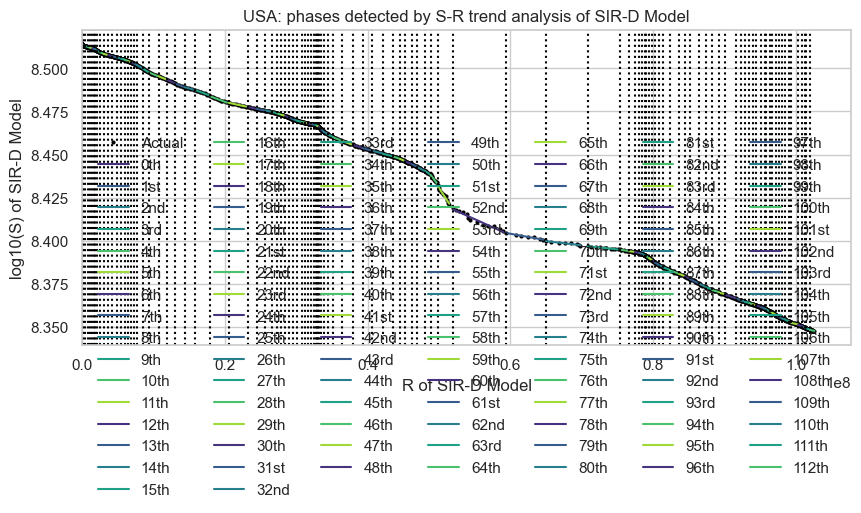

In [8]:
# Create subset of data for the country of interest and the dates of interest
# Complement does two things here: forces always increasing cumulative values, 
# estimates recovered cases using value of estimated recovery period of 10days
actual_df, _, _ = eng.subset(geo=country_ISO3, start_date='2020-02-15', end_date='2023-04-01', complement=True)

# Create a SIRF Model from actual df
dyn_act = cs.Dynamics.from_data(model=cs.SIRDModel, data=actual_df, name=country_ISO3)
dyn_act.register()

# # Breakdown of the SIRD Model Parameters and points of change
dyn_act.segment()

<AxesSubplot: ylabel='End'>

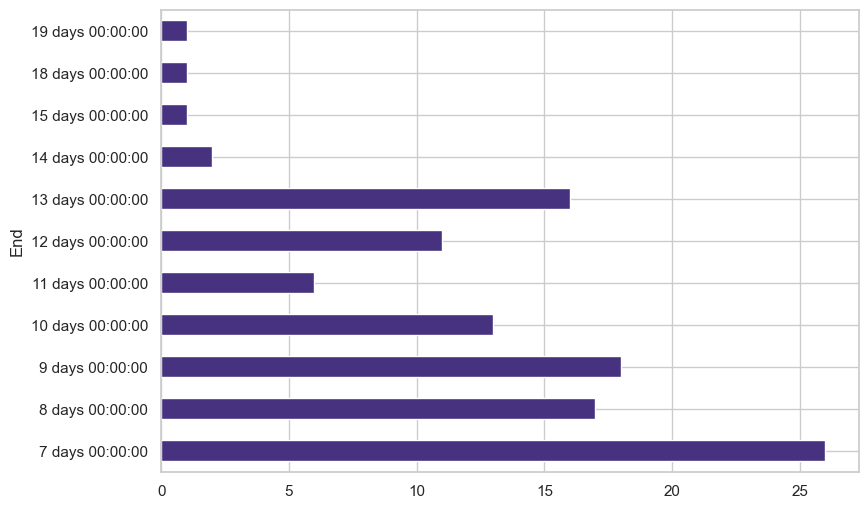

In [9]:
# Show summary
check = dyn_act.summary()

check.diff()['End'].value_counts().sort_index().plot.barh()

In [10]:
# Calculate tau value and Disease Parameters from Actual SIRF Data
dyn_act.estimate()

print(f"Tau value [min]: {dyn_act.tau or 'un-set'}")

tau_time = dyn_act.tau

dynamics_df = dyn_act.summary()
dynamics_df.head()


  0%|          | 0/113 [00:00<?, ?it/s]

Tau value [min]: 60


,Start,End,Rt,kappa,rho,sigma,1/alpha2 [day],1/beta [day],1/gamma [day]
Phase,,,,,,,,,
0th,2020-02-15,2020-03-31,39.3,0.000131,0.008776,0.000092,318,5,452
1st,2020-04-01,2020-04-11,6.44,0.000223,0.004695,0.000506,187,9,82
2nd,2020-04-12,2020-04-25,1.12,0.0002,0.002536,0.002069,208,16,20
3rd,2020-04-26,2020-05-10,0.93,0.000169,0.002431,0.002442,246,17,17
4th,2020-05-11,2020-05-21,0.84,0.000152,0.002453,0.002763,274,17,15


In [11]:

display(tau_time /dynamics_df.select_dtypes(include='float64') / 1440)

# Plot subplots for each column in track_df
dynamics_df = dynamics_df.rename(columns={'Start':'date', 'Rt': 'derived_reproduction_rate', 'kappa':'kap_mortality_rate', 
        'rho':'rho_transmission_rate', 'sigma': 'sig_recovery_rate', 
        '1/alpha2 [day]': 't/k_mortality_period', '1/beta [day]': 't/r_infection_period' , 
        '1/gamma [day]': 't/s_recovery_period'}).set_index('date').drop(columns=['End'])

,Rt,kappa,rho,sigma
Phase,,,,
0th,0.00106,317.826094,4.748,451.86837
1st,0.00647,186.662887,8.875225,82.35575
2nd,0.037202,208.105682,16.427758,20.137418
3rd,0.044803,246.234778,17.138838,17.063178
4th,0.049603,273.905067,16.985595,15.080375
...,...,...,...,...
108th,0.042088,933.284801,14.564768,14.644689
109th,0.027056,915.409607,5.041946,7.821722
110th,0.02381,1172.398191,10.067812,17.888749


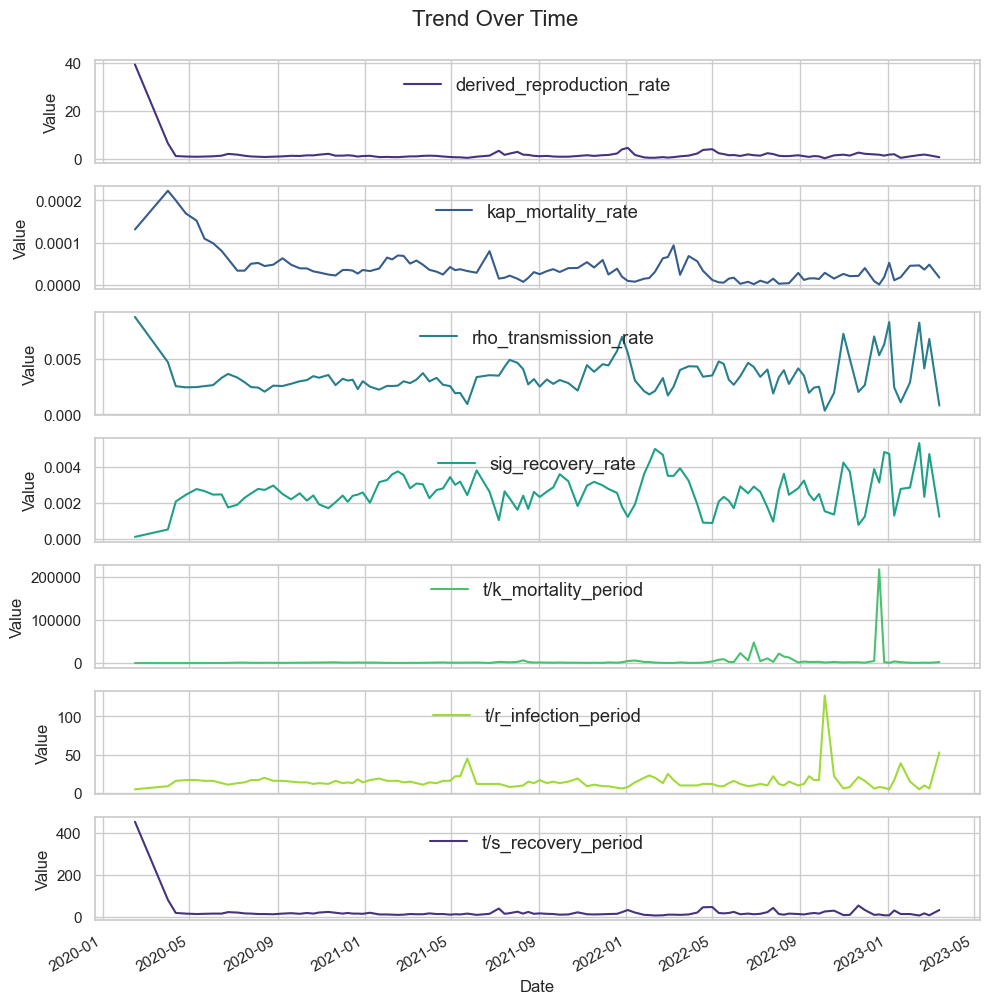

In [12]:
axrr = dynamics_df.plot(subplots=True, figsize=(10, 10), grid=True)

# Add labels to each subplot
for ax in axrr:
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    # Adjust the legend location, and set the font size
    ax.legend(loc='upper center', fontsize='large')

# Set the main title for the entire figure and adjust its position for better visibility
plt.suptitle('Trend Over Time', fontsize=16, y=1)

# Adjust the layout to add padding
plt.tight_layout(pad=1.0)

plt.show()



# <a id='toc4_'></a>[Data Loading](#toc0_)

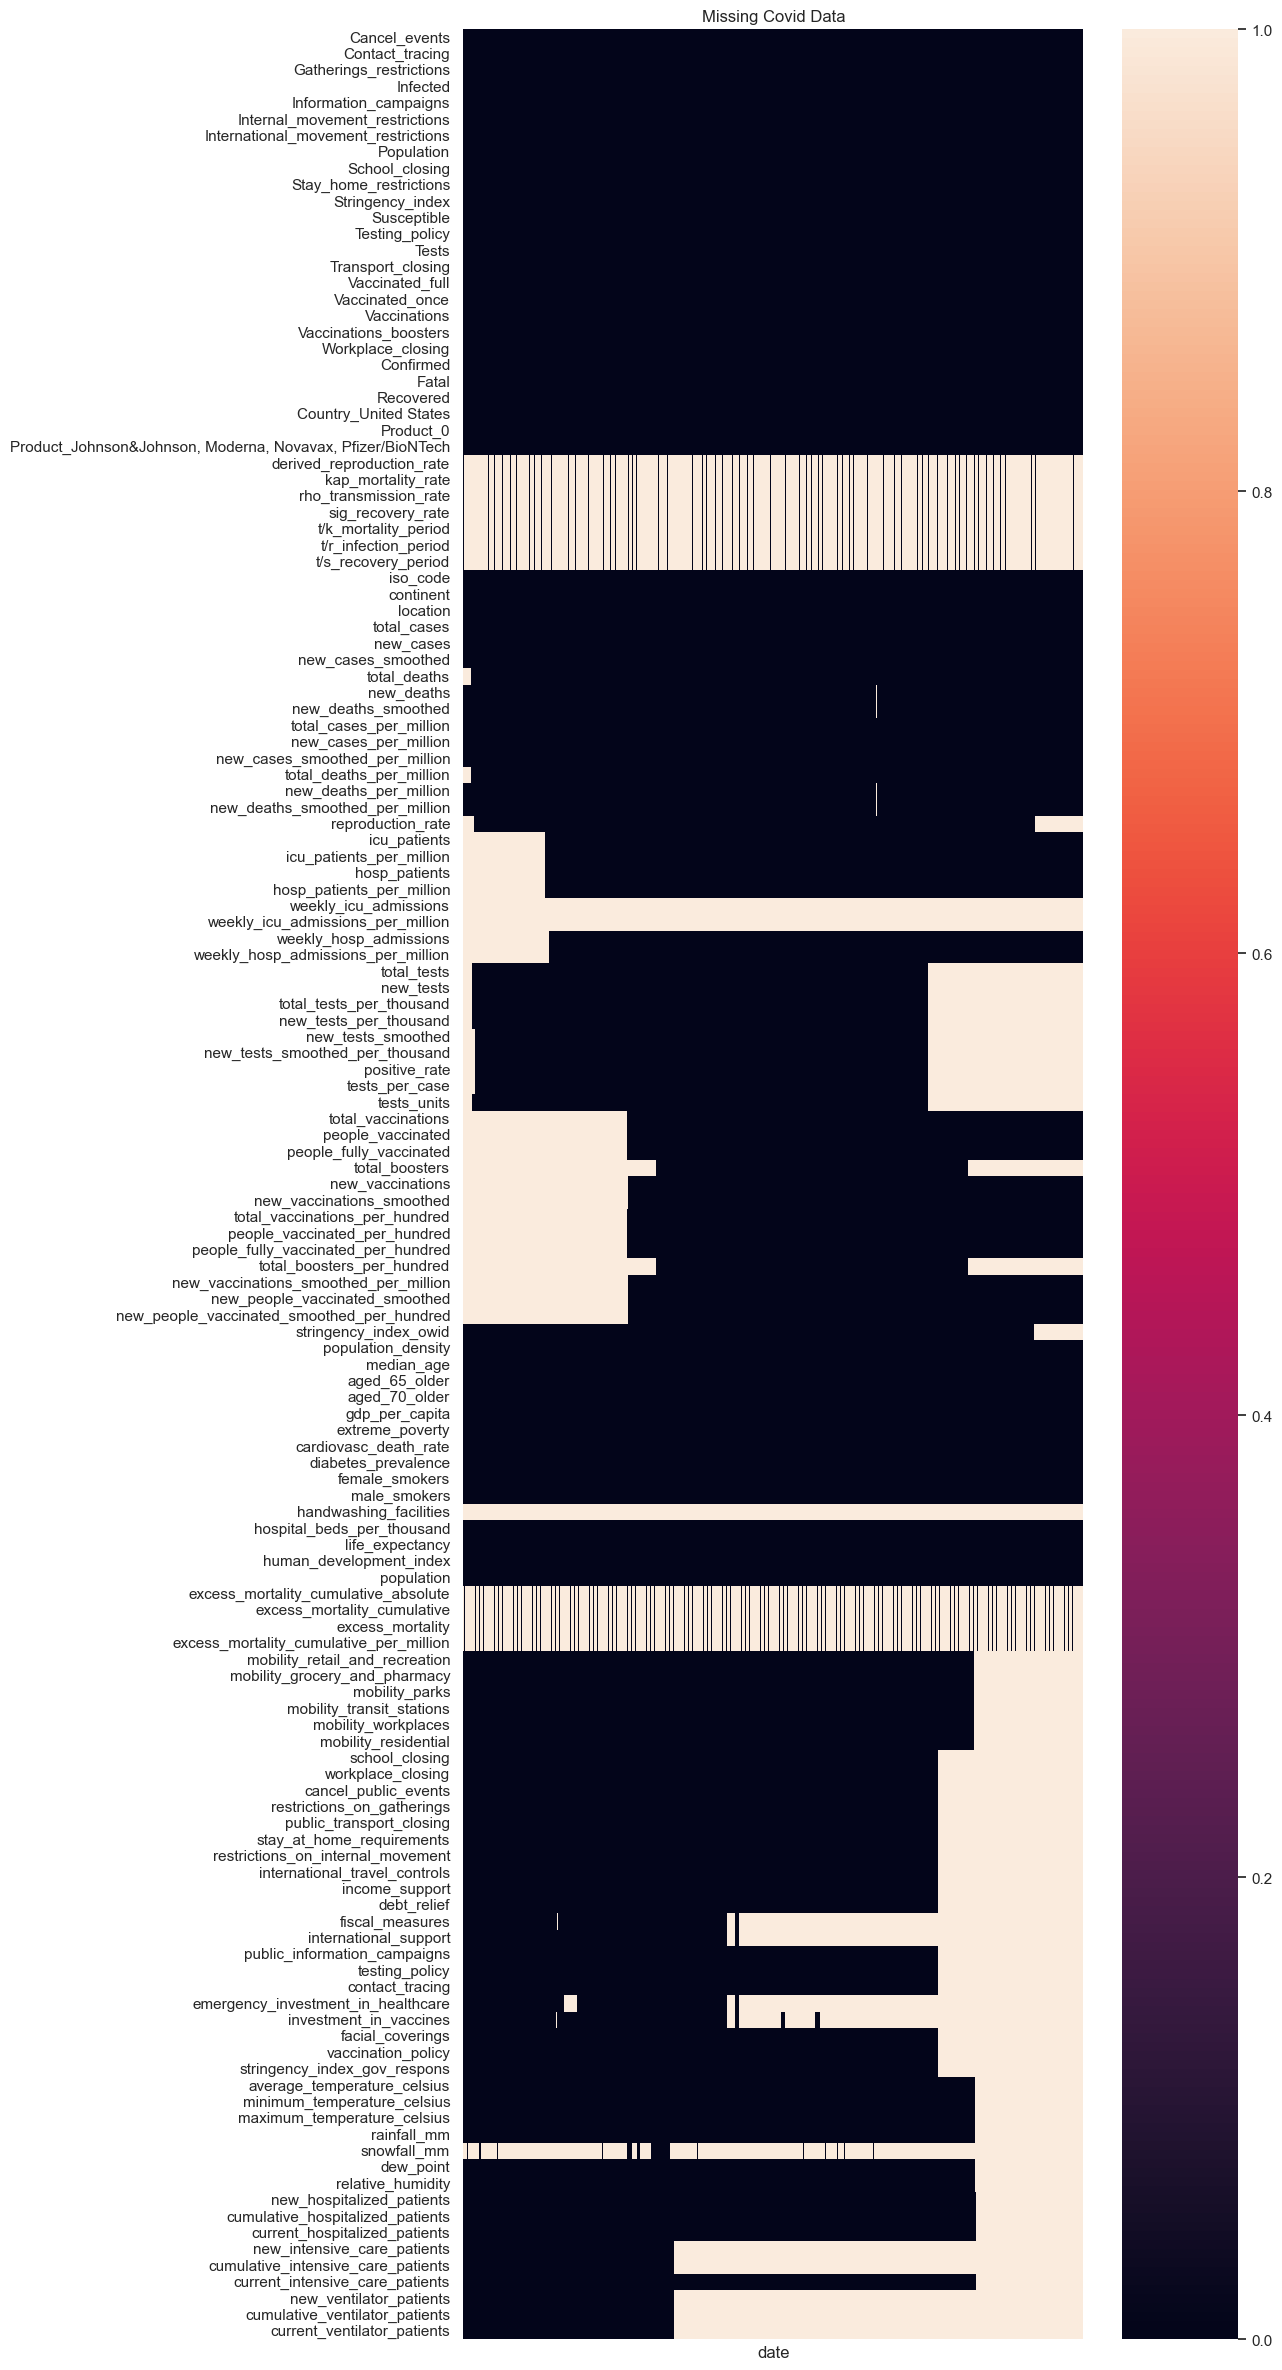

In [91]:
#  Cov
disease_df = pd.merge(actual_df, dynamics_df, how='left', left_index=True, right_index=True)
# Rename the index as 'date'
disease_df = disease_df.rename_axis('date')

# OWID Cov
owid_cov = pd.read_parquet('../Data/owid-covid-data.parquet', engine='pyarrow')
# Convert the 'date' column to datetime format
owid_cov['date'] = pd.to_datetime(owid_cov['date'])
# Set the 'date' column as the index of the DataFrame
owid_cov = owid_cov.set_index('date')

# # Load the mobility data from the CSV file
# mobility_df = pd.read_csv(f'{folder_holder}mobility.csv')
# mobility_df = clean_df(mobility_df, location_key)
# mobility_df.to_parquet(f'{folder_holder}mobility_df.parquet', engine='pyarrow')

mobility_df = pd.read_parquet(f'{folder_holder}mobility_df.parquet', engine='pyarrow')


# # Load the weather data from the CSV file
# weather_df = pd.read_csv(f'{folder_holder}weather.csv')
# weather_df = clean_df(weather_df, location_key)
# weather_df.to_parquet(f'{folder_holder}weather_df.parquet', engine='pyarrow')

weather_df = pd.read_parquet(f'{folder_holder}weather_df.parquet', engine='pyarrow')


# # Load the government response data from the CSV file
# gov_response_df = pd.read_csv(f'{folder_holder}oxford-government-response.csv')
# gov_response_df = clean_df(gov_response_df, location_key)
# gov_response_df.to_parquet(f'{folder_holder}gov_response_df.parquet', engine='pyarrow')

gov_response_df = pd.read_parquet(f'{folder_holder}gov_response_df.parquet', engine='pyarrow')


# # Load the hospitalizations data from the CSV file
# hospitalizations_df = pd.read_csv(f'{folder_holder}hospitalizations.csv')
# hospitalizations_df = clean_df(hospitalizations_df, location_key)
# hospitalizations_df.to_parquet(f'{folder_holder}hospitalizations.parquet', engine='pyarrow')

hospitalizations_df = pd.read_parquet(f'{folder_holder}hospitalizations.parquet', engine='pyarrow')

#
# Create a list of dataframes to be merged
time_series_dfs = [disease_df, owid_cov, mobility_df, gov_response_df, weather_df, hospitalizations_df]

# Use functools.reduce to merge all dataframes in the list on 'date' column, with 'left' join method
master_df = reduce(lambda a, b: pd.merge(a, b, how='left', right_on='date', left_on='date', suffixes=['_owid', '_gov_respons']), time_series_dfs)

plt.figure(figsize=(10,30))
sns.heatmap(master_df.isna().T,xticklabels = [], cbar=True)
plt.title("Missing Covid Data")
plt.show()


In [98]:
master_df.isna().sum().sum() / master_df.count().sum()


0.3071559037220441

### <a id='toc4_1_1_'></a>[CovSIRPhy Dataset Cleaning](#toc0_)

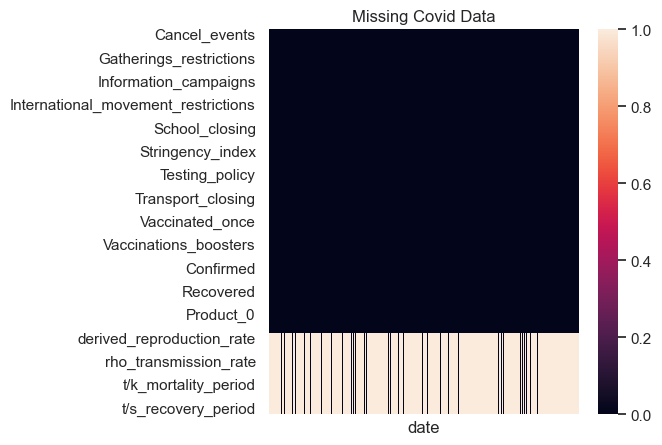

,mean,min,max,min_max_variance
Contact_tracing,1,1,1,0
Country_United States,1,1,1,0
Population,"326,687,501","326,687,501","326,687,501",0
derived_reproduction_rate,1.7554,0.21,39.3,0.0088
t/s_recovery_period,22.5841,8,452,0.009
t/k_mortality_period,"4,802.2301",187,"217,709",0.0093
t/r_infection_period,15.3274,5,127,0.0107
Infected,"1,529,243.3205",15,"13,384,650",0.0194
Information_campaigns,1.9475,0,2,0.0256
kap_mortality_rate,0,0,0.0002,0.0278


,Cancel_events,Contact_tracing,Gatherings_restrictions,Infected,Information_campaigns,Internal_movement_restrictions,International_movement_restrictions,Population,School_closing,Stay_home_restrictions,Stringency_index,Susceptible,Testing_policy,Tests,Transport_closing,Vaccinated_full,Vaccinated_once,Vaccinations,Vaccinations_boosters,Workplace_closing,Confirmed,Fatal,Recovered,Country_United States,Product_0,"Product_Johnson&Johnson, Moderna, Novavax, Pfizer/BioNTech",derived_reproduction_rate,kap_mortality_rate,rho_transmission_rate,sig_recovery_rate,t/k_mortality_period,t/r_infection_period,t/s_recovery_period
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-15,0.0,1.0,0.0,15,0.0,0.0,3.0,326687501.0,0.0,0.0,8.33,326687486.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15,0,0,1,1,0,39.3,0.000131,0.008776,0.000092,318,5,452
2020-02-16,0.0,1.0,0.0,15,0.0,0.0,3.0,326687501.0,0.0,0.0,8.33,326687486.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15,0,0,1,1,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-02-17,0.0,1.0,0.0,25,0.0,0.0,3.0,326687501.0,0.0,0.0,8.33,326687476.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25,0,0,1,1,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-02-18,0.0,1.0,0.0,25,0.0,0.0,3.0,326687501.0,0.0,0.0,8.33,326687476.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25,0,0,1,1,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-02-19,0.0,1.0,0.0,25,0.0,0.0,3.0,326687501.0,0.0,0.0,8.33,326687476.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25,0,0,1,1,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [99]:

plt.figure(figsize=(5,5))
sns.heatmap(disease_df.isna().T,xticklabels = [], cbar=True)
plt.title("Missing Covid Data")
plt.show()

quick_summary(disease_df, 15)
display(disease_df.head())

In [100]:
# Convert all column names to lowercase and replace spaces with underscores
disease_df.columns = [i.lower().replace(' ', '_') for i in disease_df.columns]

# Display the count of rows where 'confirmed' column values are greater than 'tests' column values
display(disease_df.loc[disease_df.confirmed > disease_df.tests, 'tests'].count())

# For rows where 'confirmed' column values are greater than 'tests' column values, set 'tests' column values equal to 'confirmed' column values
disease_df.loc[disease_df.confirmed > disease_df.tests, 'tests'] = disease_df.confirmed

# Display the count of rows where 'confirmed' column values are greater than 'tests' column values
display(disease_df.loc[disease_df.confirmed > disease_df.tests, 'tests'].count())


15

0

In [101]:
# Get rid of uninformative columns
disease_df.drop(columns=['product_0', 'product_johnson&johnson,_moderna,_novavax,_pfizer/biontech'], inplace=True)

display(disease_df.loc[:, disease_df.nunique() == 1].nunique())

disease_df = disease_df.loc[:, disease_df.nunique() > 1]

display(disease_df.nunique())


contact_tracing          1
population               1
country_united_states    1
dtype: int64

cancel_events                             3
gatherings_restrictions                   5
infected                               1136
information_campaigns                     2
internal_movement_restrictions            4
international_movement_restrictions       2
school_closing                            3
stay_home_restrictions                    4
stringency_index                         31
susceptible                            1124
testing_policy                            3
tests                                   849
transport_closing                         4
vaccinated_full                         841
vaccinated_once                         841
vaccinations                            841
vaccinations_boosters                   539
workplace_closing                         4
confirmed                              1124
fatal                                  1105
recovered                              1118
derived_reproduction_rate                87
kap_mortality_rate              

In [102]:
# Identify columns in 'disease_df' where the minimum value is negative
restrictions = disease_df.min()[disease_df.min() < 0]

# Take the absolute value of the data in the identified columns to make all values non-negative
disease_df.loc[:, restrictions.index] = disease_df.loc[:, restrictions.index].abs()

# Display the changed column names
restrictions.index

Index(['cancel_events', 'gatherings_restrictions',
       'internal_movement_restrictions', 'school_closing',
       'stay_home_restrictions', 'transport_closing', 'workplace_closing'],
      dtype='object')

In [103]:
# Define the non-dimensional parameters present in the dataset
non_dim_parameters = ['kap_mortality_rate', 'rho_transmission_rate', 'sig_recovery_rate'] 

# Define the dimensional parameters which are derived from the non-dimensional parameters
dimensional_parameters = ['t/k_mortality_period', 't/r_infection_period', 't/s_recovery_period']

# Update the list of parameters to include non-dimensional, dimensional, and the reproduction rate
parameters = non_dim_parameters + dimensional_parameters + ['derived_reproduction_rate']


for col in non_dim_parameters:
    try:
        disease_df[col] = disease_df[col].astype(float)
    except ValueError as e:
        print(f"Error converting column {col}: {e}")

disease_df.info()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1142 entries, 2020-02-15 to 2023-04-01
Data columns (total 28 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   cancel_events                        1142 non-null   Float64
 1   gatherings_restrictions              1142 non-null   Float64
 2   infected                             1142 non-null   Int64  
 3   information_campaigns                1142 non-null   Float64
 4   internal_movement_restrictions       1142 non-null   Float64
 5   international_movement_restrictions  1142 non-null   Float64
 6   school_closing                       1142 non-null   Float64
 7   stay_home_restrictions               1142 non-null   Float64
 8   stringency_index                     1142 non-null   Float64
 9   susceptible                          1142 non-null   Float64
 10  testing_policy                       1142 non-null   Float64
 11  tests       

,mse,mae,mape
polynomial Order 1,0.000000,0.000001,2.667424
polynomial Order 2,0.000000,0.000000,0.000300


The Lowest Mape for kap_mortality_rate is in  polynomial Order 2


,mse,mae,mape
polynomial Order 1,0.000000,0.000039,1.421440
polynomial Order 2,0.000000,0.000000,0.000103


The Lowest Mape for rho_transmission_rate is in  polynomial Order 2


,mse,mae,mape
polynomial Order 1,0.000000,0.000035,1.903236
polynomial Order 2,0.000000,0.000000,0.000151


The Lowest Mape for sig_recovery_rate is in  polynomial Order 2


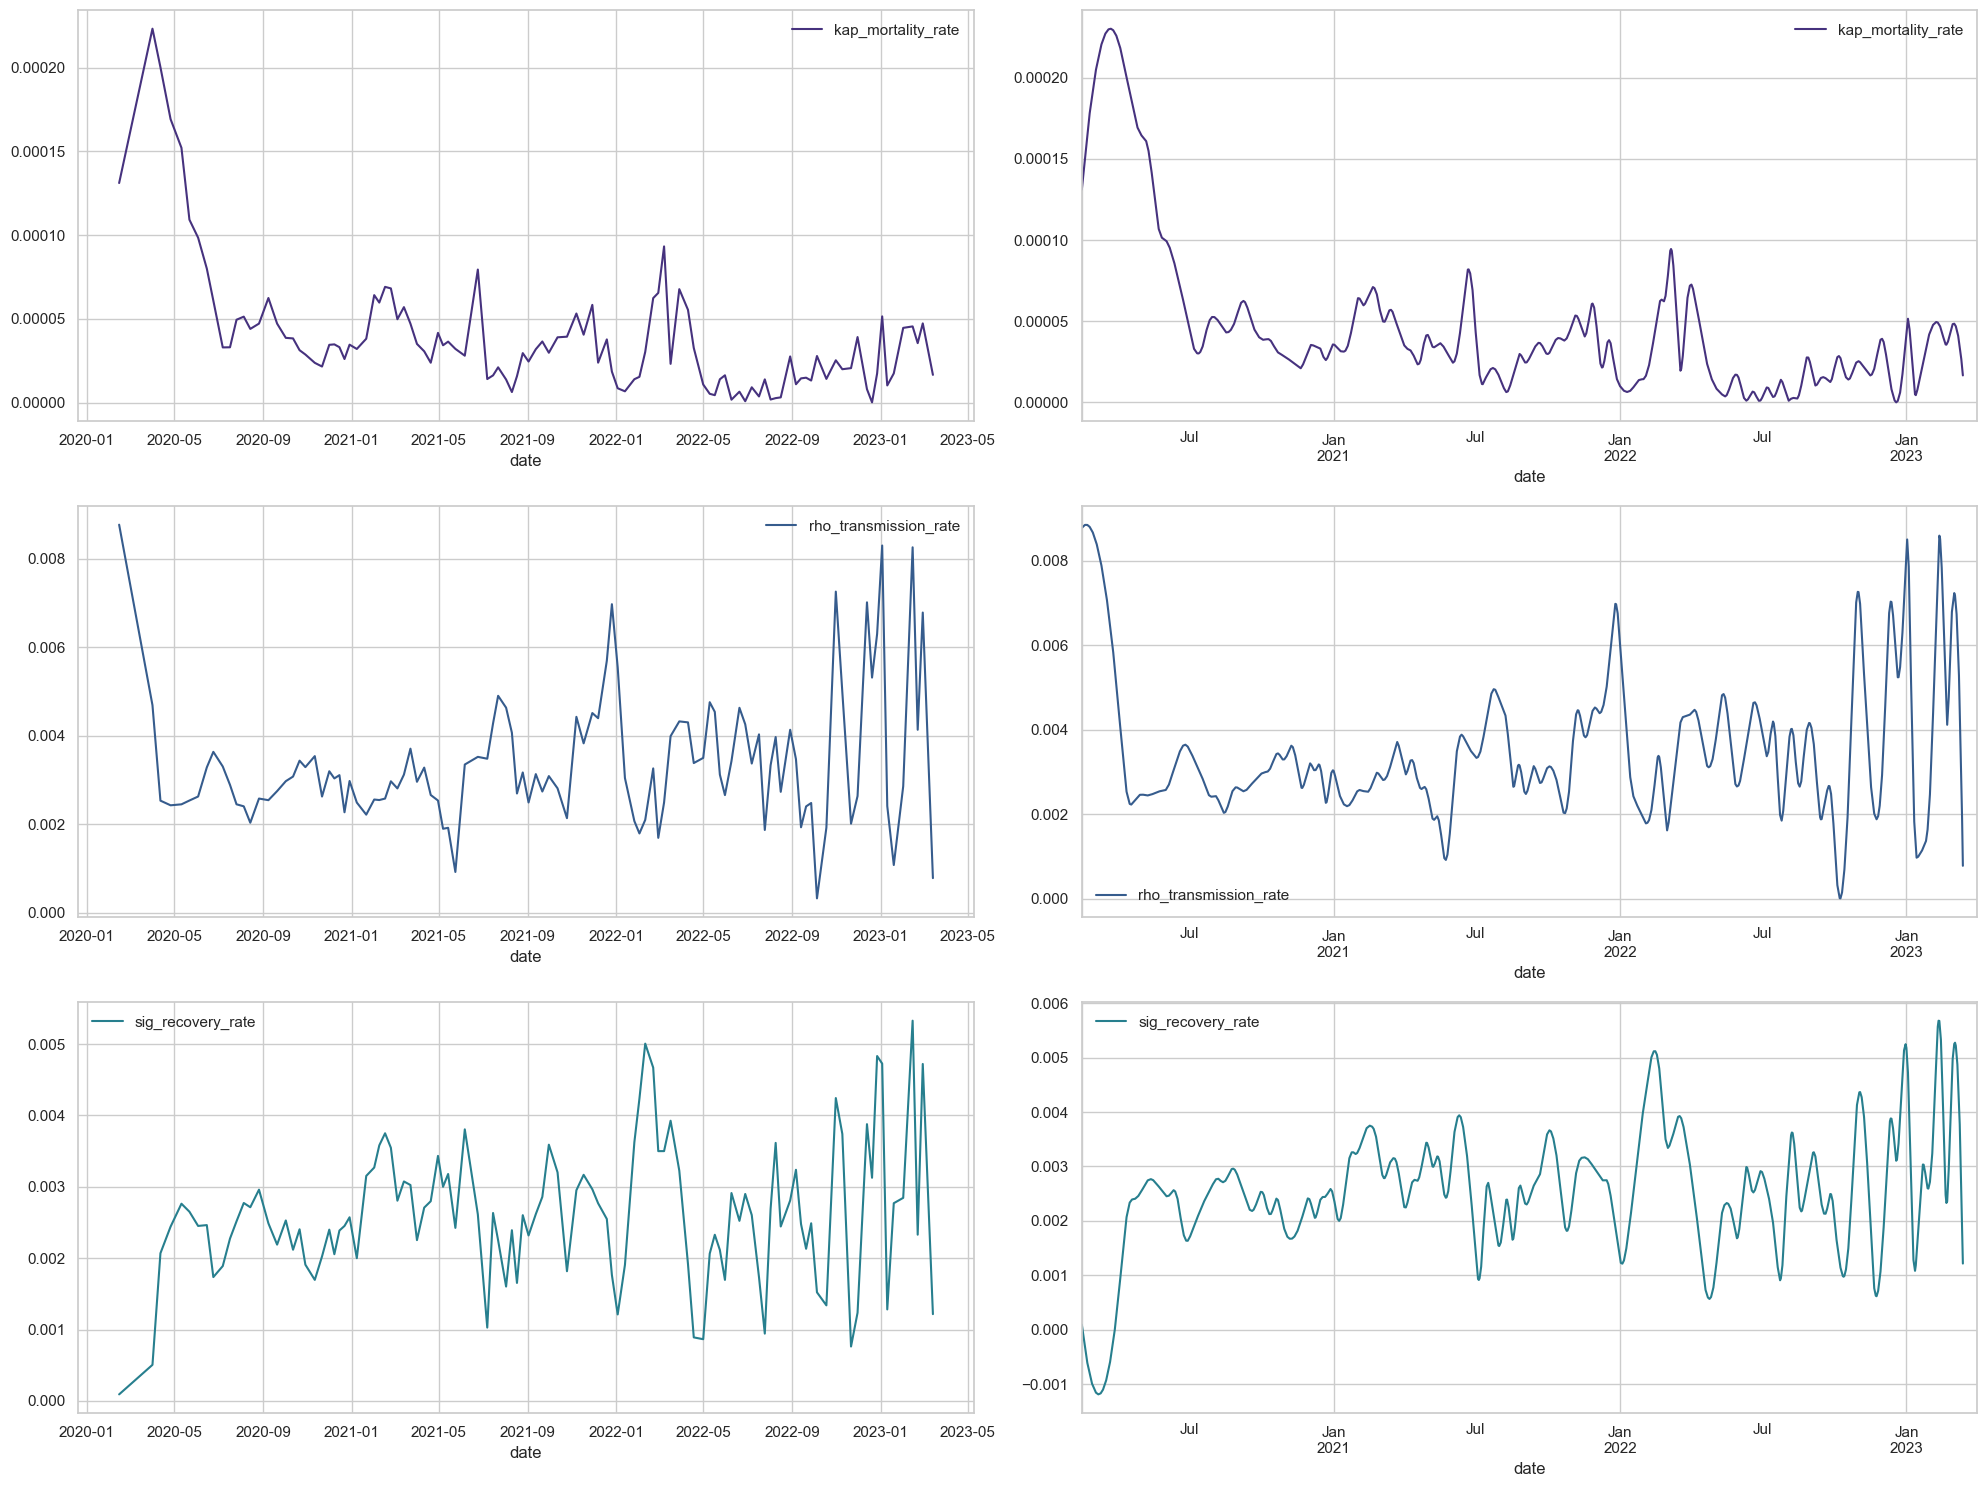

In [104]:
method = 'polynomial'
order = 2

# # # Iterate over the list of columns
for i in non_dim_parameters:
    # print("\n", i)  # Print the current column name
    train, val = train_test_validation(disease_df, i, n_splits=5, order=order, method=method, verbose=False)  # Call a function with specific parameters
    display(train.style.background_gradient(cmap='coolwarm'))  # Display the styled 'train' DataFrame

    print(f"The Lowest Mape for {i} is in ", train.mape.idxmin())  # Print the index with the lowest 'mape' value in 'train'

# Create a figure with two columns for subplots
fig, axes = plt.subplots(nrows=len(non_dim_parameters), ncols=2, figsize=(20, 15))

# Plot original data in the left column (axes[:, 0])
disease_df[non_dim_parameters].dropna().plot(subplots=True, ax=axes[:, 0], grid=True)

# Plot interpolated data in the right column (axes[:, 1])
disease_df[non_dim_parameters].interpolate(method=method, order=order).plot(subplots=True, ax=axes[:, 1], grid=True)

# plt.plot()
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
min_holder = disease_df[non_dim_parameters].min().copy()

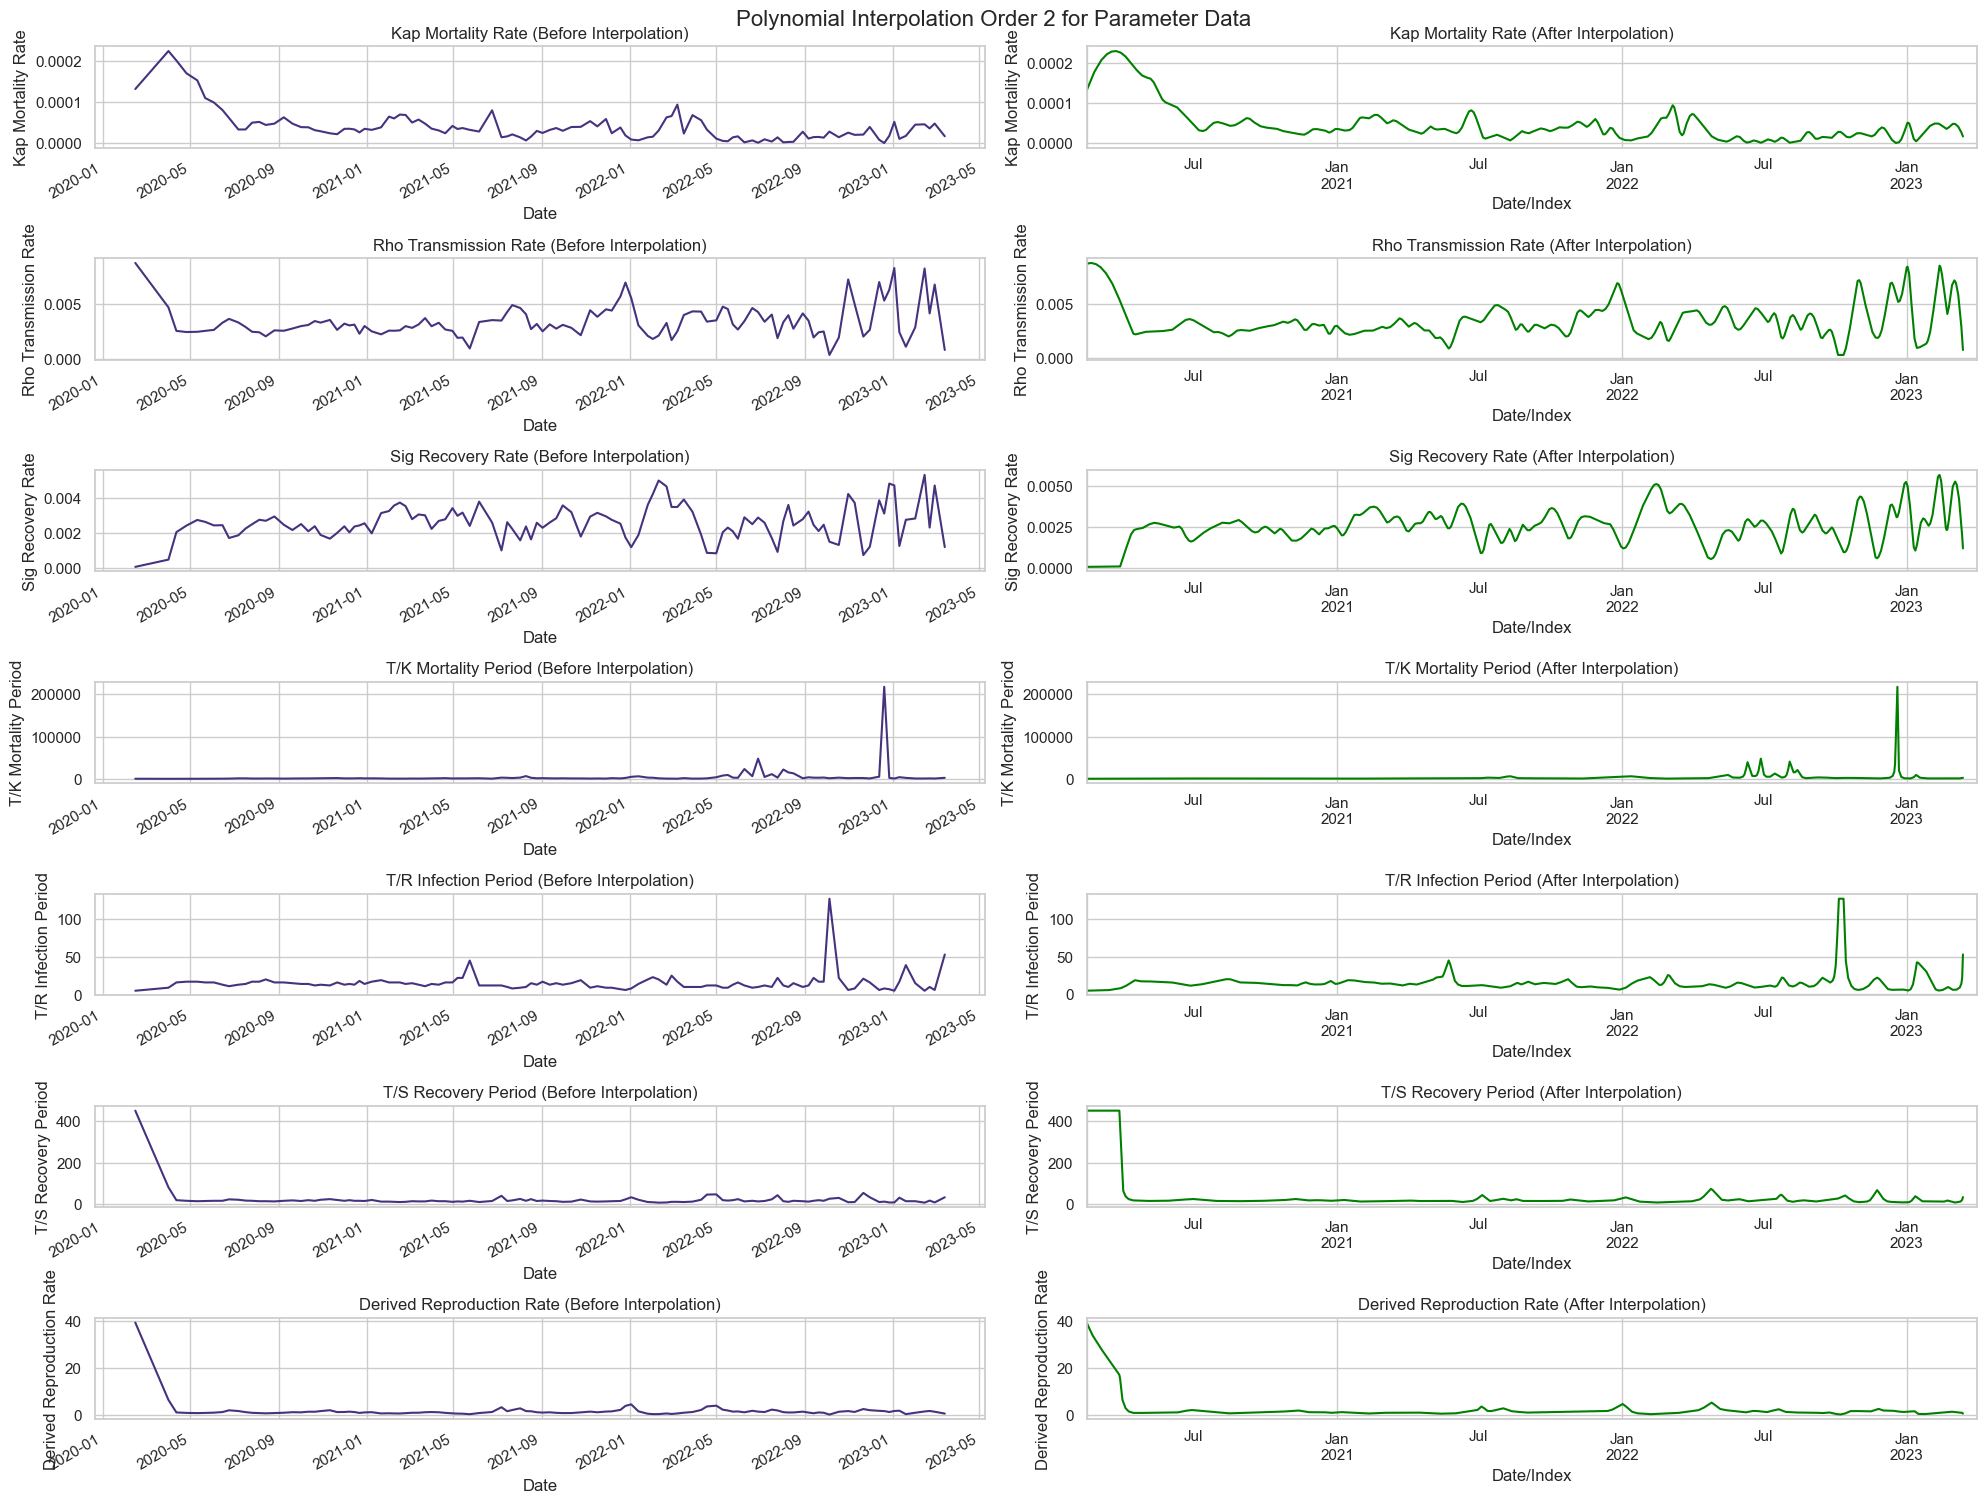

In [105]:
# Plot the original parameters in the dataframe using subplots
fig, axes = plt.subplots(nrows=len(parameters), ncols=2, figsize=(20, 15))
# Plotting original data
for idx, col in enumerate(parameters):
    disease_df[col].dropna().plot(ax=axes[idx, 0], grid=True)
    axes[idx, 0].set_title(col.replace('_', ' ').title() + ' (Before Interpolation)')
    axes[idx, 0].set_xlabel('Date')  # Assuming the x-axis represents dates or index values
    axes[idx, 0].set_ylabel(col.replace('_', ' ').title())

# Interpolate and process the data
disease_df[non_dim_parameters] = disease_df[non_dim_parameters].interpolate(method=method, order=order)
disease_df[non_dim_parameters] = np.where(disease_df[non_dim_parameters] < min_holder, min_holder, disease_df[non_dim_parameters])
disease_df[dimensional_parameters] = tau_time / disease_df[non_dim_parameters] / 1440
disease_df['derived_reproduction_rate'] = disease_df['rho_transmission_rate'] / (disease_df['sig_recovery_rate'] + disease_df['kap_mortality_rate'])

# Plotting interpolated and processed data
for idx, col in enumerate(parameters):
    disease_df[col].plot(ax=axes[idx, 1], grid=True, color='green')
    axes[idx, 1].set_title(col.replace('_', ' ').title() + ' (After Interpolation)')
    axes[idx, 1].set_xlabel('Date/Index')  # Assuming the x-axis represents dates or index values
    axes[idx, 1].set_ylabel(col.replace('_', ' ').title())

# Adjusts the layout for better visualization
plt.tight_layout() 
plt.suptitle('Polynomial Interpolation Order 2 for Parameter Data', fontsize=16, y=1) 
plt.show()


#### Transformation Issues
Potentially Losing Some data by keeping it at the minimum value of the original dataset. Consider linear interpolation instead or other always positive transformation.

In [106]:
# Display the rows in 'disease_df' where 'parameters' columns have missing values
display(disease_df[parameters][disease_df[parameters].isna()])

# Fill missing values in 'parameters' columns using backfill and forward fill
disease_df[parameters] = disease_df[parameters].fillna(method='bfill').fillna(method='ffill')

# Count the number of missing values in 'parameters' columns
disease_df[parameters].isna().sum()


,kap_mortality_rate,rho_transmission_rate,sig_recovery_rate,t/k_mortality_period,t/r_infection_period,t/s_recovery_period,derived_reproduction_rate
date,,,,,,,
2020-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2023-03-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN


kap_mortality_rate           0
rho_transmission_rate        0
sig_recovery_rate            0
t/k_mortality_period         0
t/r_infection_period         0
t/s_recovery_period          0
derived_reproduction_rate    0
dtype: int64

### <a id='toc4_1_2_'></a>[Owid Dataset](#toc0_)

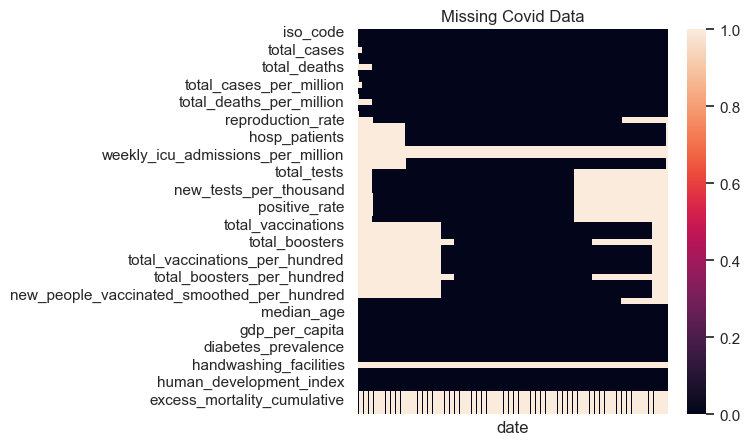

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1287 entries, 2020-01-03 to 2023-07-12
Data columns (total 66 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   iso_code                                    1287 non-null   object 
 1   continent                                   1287 non-null   object 
 2   location                                    1287 non-null   object 
 3   total_cases                                 1270 non-null   float64
 4   new_cases                                   1287 non-null   float64
 5   new_cases_smoothed                          1282 non-null   float64
 6   total_deaths                                1230 non-null   float64
 7   new_deaths                                  1286 non-null   float64
 8   new_deaths_smoothed                         1281 non-null   float64
 9   total_cases_per_million                     1270 non-null   float64

<AxesSubplot: >

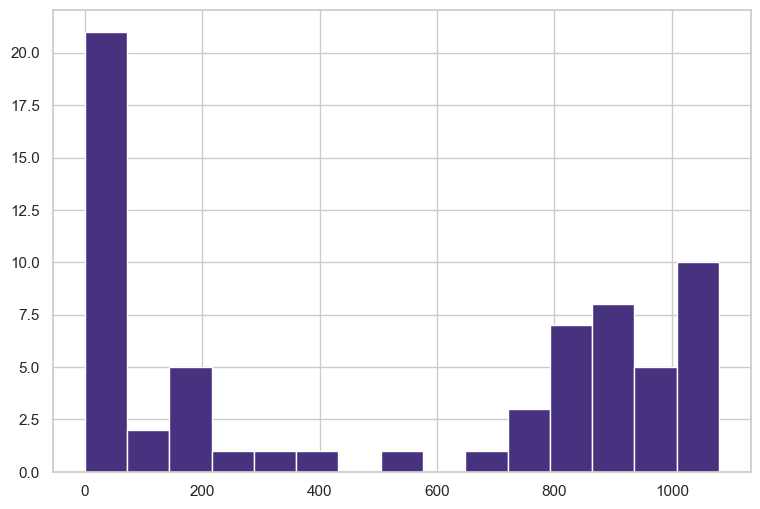

In [107]:

plt.figure(figsize=(5,5))
sns.heatmap(owid_cov.isna().T,xticklabels = [], cbar=True)
plt.title("Missing Covid Data")
plt.show()

# Display information about the DataFrame 'owid_cov'
owid_cov.info()

# Create a histogram of the number of unique values in each column of 'owid_cov'
owid_cov.nunique().hist(bins=15)


In [108]:
owid_cov.nunique().sort_values().head(25)

weekly_icu_admissions                  0
handwashing_facilities                 0
weekly_icu_admissions_per_million      0
population_density                     1
median_age                             1
aged_65_older                          1
aged_70_older                          1
gdp_per_capita                         1
extreme_poverty                        1
iso_code                               1
female_smokers                         1
male_smokers                           1
hospital_beds_per_thousand             1
life_expectancy                        1
human_development_index                1
population                             1
cardiovasc_death_rate                  1
diabetes_prevalence                    1
tests_units                            1
continent                              1
location                               1
reproduction_rate                    132
tests_per_case                       143
excess_mortality_cumulative          161
excess_mortality

In [109]:

# Select columns in 'owid_cov' that have more than 10 unique values
owid_cov = owid_cov.loc[:, owid_cov.nunique() > 10]

# Drop specified columns from 'owid_cov'

owid_cov.drop(columns=['total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed',
            'new_tests_smoothed_per_thousand', 'new_cases_smoothed', 'new_deaths_smoothed',
            'excess_mortality_cumulative_per_million', 'total_boosters_per_hundred', 
            'new_vaccinations_smoothed', 'total_vaccinations_per_hundred',	'people_vaccinated_per_hundred',	
            'people_fully_vaccinated_per_hundred',	'new_vaccinations_smoothed_per_million',	
            'new_people_vaccinated_smoothed',	'new_people_vaccinated_smoothed_per_hundred',
            'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 
            'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'new_deaths_smoothed', 'weekly_hosp_admissions', 
            'icu_patients_per_million', 'hosp_patients_per_million', 'weekly_hosp_admissions_per_million'], inplace=True)


In [110]:

# Perform aggregation and styling on 'owid_cov', and display the result
display(
        last_first_missing(owid_cov, True).style
                .background_gradient(cmap='coolwarm', subset=['percent', 'min_max_variance'])
                .format(lambda x: "{:,.4f}".format(x).rstrip('0').rstrip('.') if isinstance(x, (float, int)) else x)
        )


,First_Data_Date,Last_Data_Date,percent,min_max_variance,min,max,mean
excess_mortality,2020-01-05,2023-05-21,86.2471,0.058,-4.2,46.02,12.6522
excess_mortality_cumulative,2020-01-05,2023-05-21,86.2471,0.0564,-4.2,17.51,12.9871
excess_mortality_cumulative_absolute,2020-01-05,2023-05-21,86.2471,0.1172,"-13,646.999","1,276,845","740,688.7045"
total_boosters,2021-02-04,2022-09-01,55.3225,0.1605,1,"133,062,763","53,957,174.5617"
positive_rate,2020-03-07,2022-06-18,35.1981,0.0382,0.017,0.292,0.0853
tests_per_case,2020-03-07,2022-06-18,35.1981,0.0403,3.4,58.8,16.7765
total_tests,2020-03-01,2022-06-18,34.7319,0.106,348,"912,769,124","410,386,446.7012"
new_tests,2020-03-01,2022-06-18,34.7319,0.0348,348,"3,201,706","1,086,629.9095"
new_vaccinations,2020-12-14,2023-05-09,31.857,0.0339,"2,556","4,581,777","771,588.5542"
total_vaccinations,2020-12-13,2023-05-09,31.7793,0.0879,"45,620","676,728,782","471,846,074.5718"


In [111]:
# Iterate over the list of columns
for i in ['excess_mortality_cumulative', 'excess_mortality', 'excess_mortality_cumulative_absolute']:
    print("\n\n", i)  # Print the current column name
    train, val = train_test_validation(owid_cov, i, n_splits=5, order=2, method='polynomial')  # Call a function with specific parameters
    display('train', train.style.background_gradient(cmap='coolwarm'))  # Display the styled 'train' DataFrame
    # display('val', val)  # Display the 'val' DataFrame (commented out)

    print("The Lowest Mape is in ", train.mape.idxmin())  # Print the index with the lowest 'mape' value in 'train'

# Display the first five rows of specific columns in 'owid_cov' DataFrame
owid_cov[['excess_mortality_cumulative', 'excess_mortality', 'excess_mortality_cumulative_absolute']].head(5)




 excess_mortality_cumulative


'train'

,mse,mae,mape
polynomial Order 1,0.000222,0.008382,0.331030
polynomial Order 2,0.000000,0.000000,0.000000


The Lowest Mape is in  polynomial Order 2


 excess_mortality


'train'

,mse,mae,mape
polynomial Order 1,0.076825,0.199682,3.745263
polynomial Order 2,0.000000,0.000000,0.000000


The Lowest Mape is in  polynomial Order 2


 excess_mortality_cumulative_absolute


'train'

,mse,mae,mape
polynomial Order 1,28663.788925,116.012250,0.386285
polynomial Order 2,0.000000,0.000000,0.000000


The Lowest Mape is in  polynomial Order 2


,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_absolute
date,,,
2020-01-03,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN
2020-01-05,-4.2,-4.2,-2640.0
2020-01-06,NaN,NaN,NaN
2020-01-07,NaN,NaN,NaN


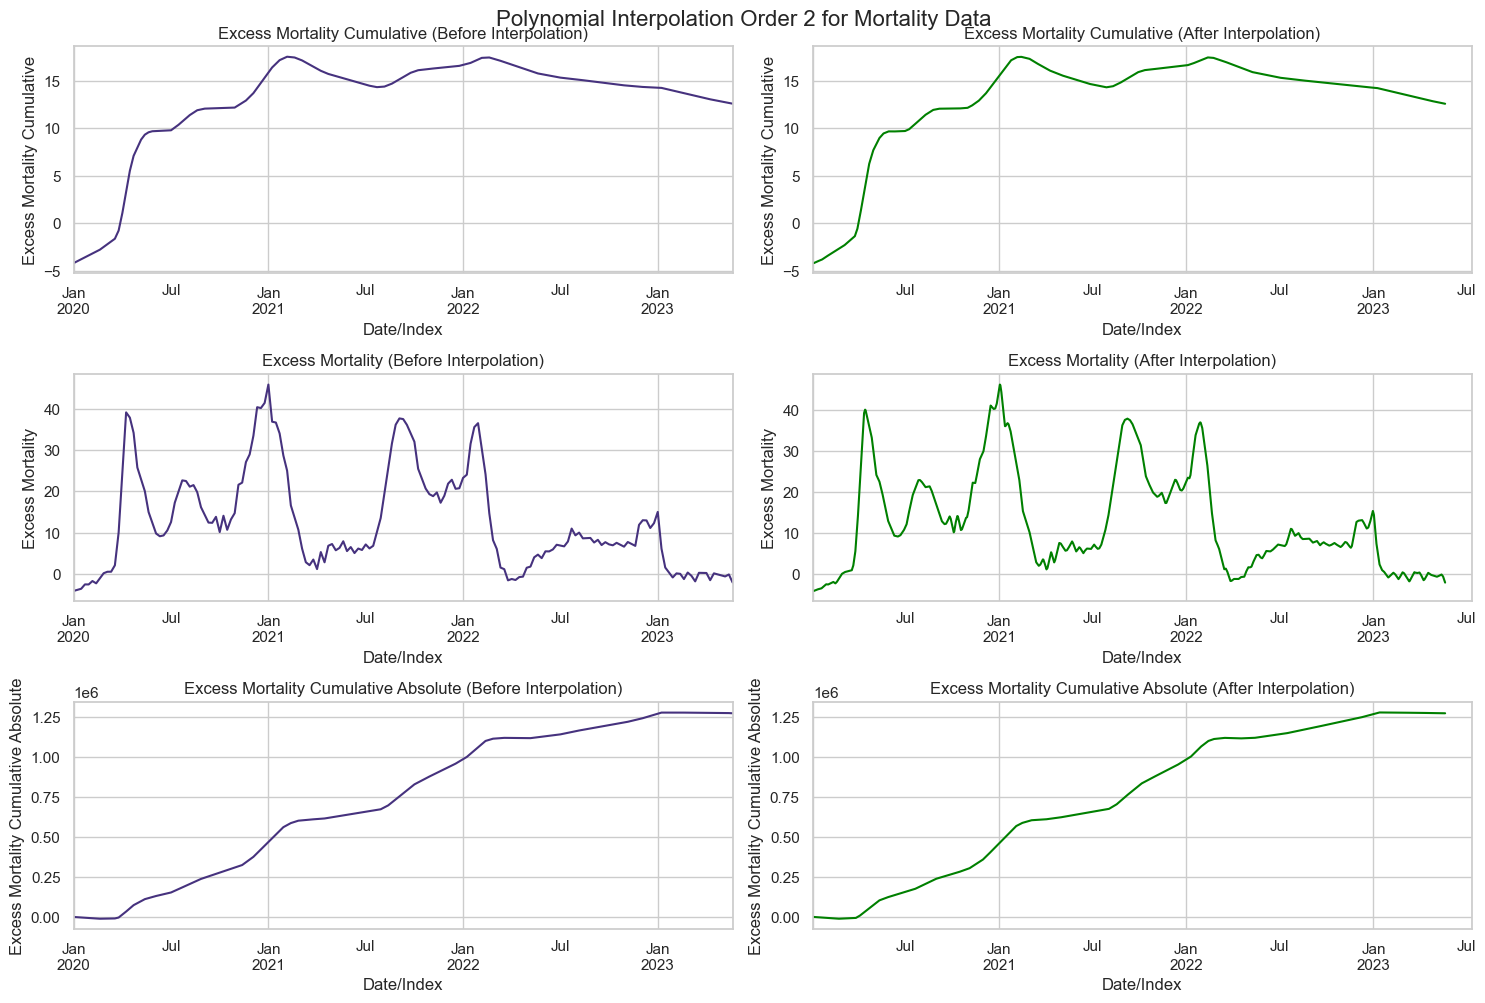

In [112]:
import matplotlib.pyplot as plt

# Define a figure and a grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))

# Names of the columns to be plotted
columns = ['excess_mortality_cumulative', 'excess_mortality', 'excess_mortality_cumulative_absolute']

# Plotting the data before interpolation
for idx, col in enumerate(columns):
    owid_cov[col].dropna().plot(ax=axes[idx, 0], grid=True)
    axes[idx, 0].set_title(col.replace('_', ' ').title()  + ' (Before Interpolation)')
    axes[idx, 0].set_xlabel('Date/Index')  # Assuming the x-axis represents dates or index values
    axes[idx, 0].set_ylabel(col.replace('_', ' ').title() )

# Interpolate the columns
owid_cov['excess_mortality_cumulative'] = owid_cov['excess_mortality_cumulative'].interpolate(order=2, method='polynomial')
owid_cov['excess_mortality'] = owid_cov['excess_mortality'].interpolate(order=2, method='polynomial')
owid_cov['excess_mortality_cumulative_absolute'] = owid_cov['excess_mortality_cumulative_absolute'].interpolate(order=2, method='polynomial')

# Plotting the data after interpolation
for idx, col in enumerate(columns):
    owid_cov[col].plot(ax=axes[idx, 1], grid=True, color='green')
    axes[idx, 1].set_title(col.replace('_', ' ').title()  + ' (After Interpolation)')
    axes[idx, 1].set_xlabel('Date/Index')  # Assuming the x-axis represents dates or index values
    axes[idx, 1].set_ylabel(col.replace('_', ' ').title() )

# Adjust layout for better presentation
plt.tight_layout()
plt.suptitle('Polynomial Interpolation Order 2 for Mortality Data', fontsize=16, y=1) 
plt.show()


In [113]:
# Display the rows in 'disease_df' where 'parameters' columns have missing values
display(owid_cov[['excess_mortality_cumulative', 'excess_mortality', 'excess_mortality_cumulative_absolute']]
        [owid_cov['excess_mortality_cumulative'].isna()].head())

# # If there are still NaN values at the beginning or end, you can use ffill or bfill to handle them
owid_cov[['excess_mortality_cumulative', 'excess_mortality', 'excess_mortality_cumulative_absolute']] = \
    owid_cov[['excess_mortality_cumulative', 'excess_mortality', 'excess_mortality_cumulative_absolute']].fillna(method='bfill').fillna(method='ffill')

# Count the number of missing values in 'parameters' columns
owid_cov[['excess_mortality_cumulative', 'excess_mortality', 'excess_mortality_cumulative_absolute']].isna().sum()


,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_absolute
date,,,
2020-01-03,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN
2023-05-22,NaN,NaN,NaN
2023-05-23,NaN,NaN,NaN
2023-05-24,NaN,NaN,NaN


excess_mortality_cumulative             0
excess_mortality                        0
excess_mortality_cumulative_absolute    0
dtype: int64

## <a id='toc4_2_'></a>[Google Datasets Loading and Cleaning](#toc0_)

### <a id='toc4_2_1_'></a>[Mobility Data](#toc0_)

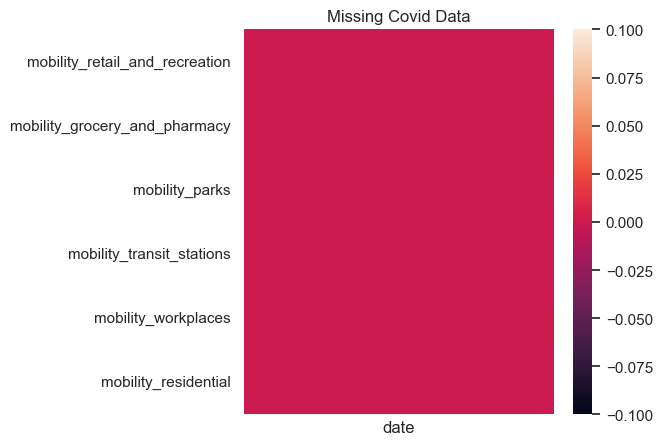

(mobility_retail_and_recreation    0
 mobility_grocery_and_pharmacy     0
 mobility_parks                    0
 mobility_transit_stations         0
 mobility_workplaces               0
 mobility_residential              0
 dtype: int64,
 mobility_retail_and_recreation     68
 mobility_grocery_and_pharmacy      54
 mobility_parks                    116
 mobility_transit_stations          64
 mobility_workplaces                70
 mobility_residential               28
 dtype: int64)

In [114]:
# looking at nulls and unique values

plt.figure(figsize=(5,5))
sns.heatmap(mobility_df.isna().T,xticklabels = [], cbar=True)
plt.title("Missing Covid Data")
plt.show()

mobility_df.isna().sum(), mobility_df.nunique()

In [115]:

# short preview of the data


display(
        last_first_missing(mobility_df, True).sort_values(by='min_max_variance')
                .style.background_gradient(cmap='coolwarm', subset='min_max_variance', vmin=0, vmax=.1)
                .format(lambda x: "{:,.4f}".format(x).rstrip('0').rstrip('.') if isinstance(x, (float, int)) else x)
        )


,First_Data_Date,Last_Data_Date,percent,min_max_variance,min,max,mean
mobility_grocery_and_pharmacy,2020-02-15,2022-09-12,0,0.006,-61,36,-2.5303
mobility_retail_and_recreation,2020-02-15,2022-09-12,0,0.0128,-82,14,-12.6355
mobility_workplaces,2020-02-15,2022-09-12,0,0.0213,-84,5,-25.9224
mobility_transit_stations,2020-02-15,2022-09-12,0,0.0223,-67,7,-25.8183
mobility_parks,2020-02-15,2022-09-12,0,0.0282,-38,127,20.5887
mobility_residential,2020-02-15,2022-09-12,0,0.0283,-2,27,6.9001


### <a id='toc4_2_2_'></a>[Weather Data](#toc0_)

average_temperature_celsius      0
minimum_temperature_celsius      0
maximum_temperature_celsius      0
rainfall_mm                      0
snowfall_mm                    882
dew_point                        0
relative_humidity                0
dtype: int64

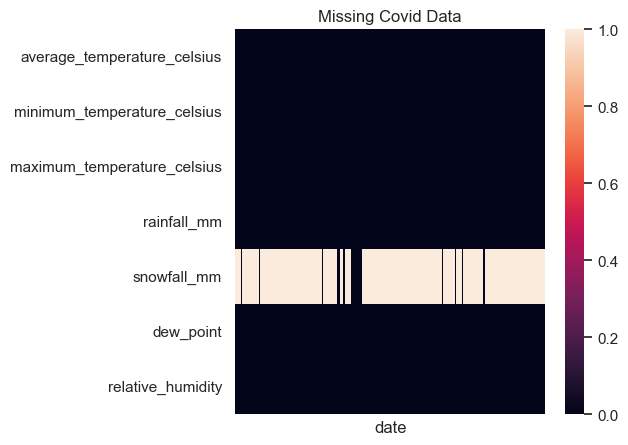

In [116]:
# Display the count of missing values in each column of 'weather_df'
display(weather_df.isna().sum())

plt.figure(figsize=(5,5))
sns.heatmap(weather_df.isna().T,xticklabels = [], cbar=True)
plt.title("Missing Covid Data")
plt.show()


In [117]:

# Fill the missing values in 'weather_df' with 0
weather_df = weather_df.fillna(0)

# Display the count of missing values in each column of 'weather_df' after filling with 0
weather_df.isna().sum()



average_temperature_celsius    0
minimum_temperature_celsius    0
maximum_temperature_celsius    0
rainfall_mm                    0
snowfall_mm                    0
dew_point                      0
relative_humidity              0
dtype: int64

In [118]:

# Perform aggregation and styling on 'weather_df', and display the result

display(
        last_first_missing(weather_df, True).sort_values(by='min_max_variance')
                .style.background_gradient(cmap='coolwarm', subset='min_max_variance', vmin=0, vmax=.1)
                .format(lambda x: "{:,.4f}".format(x).rstrip('0').rstrip('.') if isinstance(x, (float, int)) else x)
        )


,First_Data_Date,Last_Data_Date,percent,min_max_variance,min,max,mean
rainfall_mm,2020-02-03,2022-09-14,0,0.0042,0,68.4107,1.5245
snowfall_mm,2020-02-03,2022-09-14,0,0.0202,0,239.6067,8.0917
maximum_temperature_celsius,2020-02-03,2022-09-14,0,0.0369,-18.7944,40.05,21.3234
relative_humidity,2020-02-03,2022-09-14,0,0.038,23.8291,93.1456,59.8242
average_temperature_celsius,2020-02-03,2022-09-14,0,0.0385,-24.1833,31.5722,13.0534
minimum_temperature_celsius,2020-02-03,2022-09-14,0,0.0395,-29.4944,24.1389,6.4332
dew_point,2020-02-03,2022-09-14,0,0.0439,-28.7889,21.85,4.9715


### <a id='toc4_2_3_'></a>[Government Response](#toc0_)

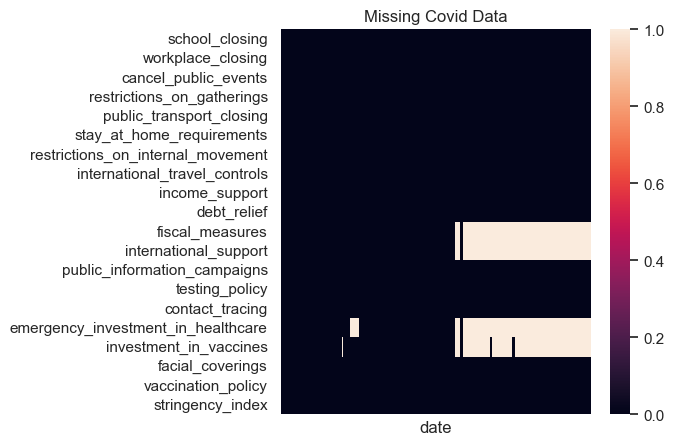

,First_Data_Date,Last_Data_Date,percent,min_max_variance,min,max,mean
contact_tracing,2020-02-03,2022-07-07,0,0,1,1,1
investment_in_vaccines,2020-02-03,2021-12-01,41.7607,0.0022,0,"9,000,000,000","31,100,775.1938"
international_support,2020-02-03,2021-07-05,43.1151,0.0022,0,"1,300,000,000","4,307,440.4762"
emergency_investment_in_healthcare,2020-02-03,2021-07-05,45.9368,0.0026,0,"242,400,000,000","849,454,592.9019"
fiscal_measures,2020-02-03,2021-07-05,43.228,0.0044,0,"1,957,600,000,000","10,606,759,443.34"
testing_policy,2020-02-03,2022-07-07,0,0.0307,0,3,2.8928
workplace_closing,2020-02-03,2022-07-07,0,0.0405,0,3,1.9718
stringency_index,2020-02-03,2022-07-07,0,0.0417,5.56,75.46,57.8901
public_information_campaigns,2020-02-03,2022-07-07,0,0.0452,0,2,1.9052
public_transport_closing,2020-02-03,2022-07-07,0,0.0462,0,1,0.9515


In [119]:
# Perform aggregation and styling and display the result

plt.figure(figsize=(5,5))
sns.heatmap(gov_response_df.isna().T,xticklabels = [], cbar=True)
plt.title("Missing Covid Data")
plt.show()


display(
        last_first_missing(gov_response_df, True).sort_values(by='min_max_variance')
                .style.background_gradient(cmap='coolwarm', subset='min_max_variance', vmin=0, vmax=.1)
                .format(lambda x: "{:,.4f}".format(x).rstrip('0').rstrip('.') if isinstance(x, (float, int)) else x)
        )


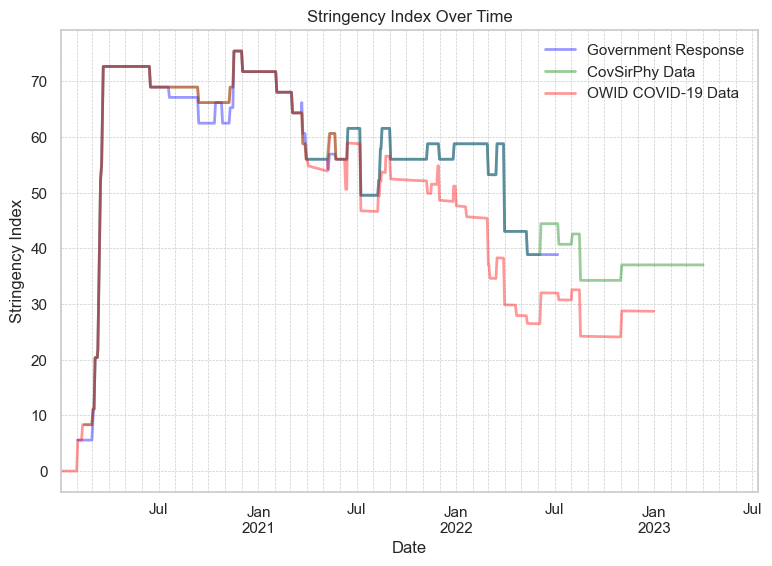

In [120]:
# Plot the 'stringency_index' from 'gov_response_df' with appropriate styling
gov_response_df.stringency_index.plot(color='blue', linewidth=2, alpha=.4, label='Government Response')

# Plot the 'stringency_index' from 'disease_df' with appropriate styling
disease_df.stringency_index.plot(color='green', linewidth=2, alpha=.4, label='CovSirPhy Data')

# Plot the 'stringency_index' from 'owid_cov' with appropriate styling
owid_cov.stringency_index.plot(color='red', linewidth=2, alpha=.4, label='OWID COVID-19 Data')

# Display the legend to indicate which line corresponds to each dataset
plt.legend()

# Add title and axis labels for clarity
plt.title('Stringency Index Over Time')
plt.xlabel('Date')
plt.ylabel('Stringency Index')

# Enhance grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()


In [121]:
# Identify columns common to 'disease_df' and 'gov_response_df'.
list_of_same_columns = list(disease_df.columns[disease_df.columns.isin(gov_response_df.columns)])
print(list_of_same_columns)

owid_cov.drop(columns=['stringency_index'], inplace=True)

['school_closing', 'stringency_index', 'testing_policy', 'workplace_closing']


In [122]:

# Identify columns common to 'disease_df' and 'gov_response_df'.
list_of_same_columns = list(disease_df.columns[disease_df.columns.isin(gov_response_df.columns)])
list_of_same_columns.extend(['fiscal_measures', 'international_support', 'investment_in_vaccines', 
            'emergency_investment_in_healthcare', 'cancel_public_events', 
            'restrictions_on_gatherings', 'restrictions_on_internal_movement', 
            'international_travel_controls', 'public_information_campaigns', 'stay_at_home_requirements',
            'public_transport_closing', 'income_support', 'debt_relief', 'contact_tracing', ])

print(list_of_same_columns)

# # Remove the common columns from 'gov_response_df'.
gov_response_df = gov_response_df.drop(columns = list_of_same_columns)


['school_closing', 'stringency_index', 'testing_policy', 'workplace_closing', 'fiscal_measures', 'international_support', 'investment_in_vaccines', 'emergency_investment_in_healthcare', 'cancel_public_events', 'restrictions_on_gatherings', 'restrictions_on_internal_movement', 'international_travel_controls', 'public_information_campaigns', 'stay_at_home_requirements', 'public_transport_closing', 'income_support', 'debt_relief', 'contact_tracing']


In [123]:

# Perform aggregation and styling on the remaining columns of 'gov_response_df', and display the result
display(gov_response_df.agg(['mean', 'min', 'max', min_max_variance])
                .T
                .sort_values('min_max_variance').head(15)
                .style
                .background_gradient(cmap='coolwarm', subset='min_max_variance', vmin=0, vmax=.1)
                .format(lambda x: "{:,.4f}".format(x).rstrip('0').rstrip('.') if isinstance(x, (float, int)) else x))


display(
        last_first_missing(gov_response_df, True).sort_values(by='min_max_variance')
                .style.background_gradient(cmap='coolwarm', subset='min_max_variance', vmin=0, vmax=.1)
                .format(lambda x: "{:,.4f}".format(x).rstrip('0').rstrip('.') if isinstance(x, (float, int)) else x)
        )


,mean,min,max,min_max_variance
facial_coverings,2.9786,0,4,0.0541
vaccination_policy,2.7156,0,5,0.2181


,First_Data_Date,Last_Data_Date,percent,min_max_variance,min,max,mean
facial_coverings,2020-02-03,2022-07-07,0,0.0541,0,4,2.9786
vaccination_policy,2020-02-03,2022-07-07,0,0.2181,0,5,2.7156


### <a id='toc4_2_4_'></a>[Hospitalization Data](#toc0_)

In [124]:
# Perform aggregation and styling on 'hospitalizations_df', and display the result

display(
        last_first_missing(hospitalizations_df, True).sort_values(by='min_max_variance')
                .style.background_gradient(cmap='coolwarm', subset='min_max_variance', vmin=0, vmax=.1)
                .format(lambda x: "{:,.4f}".format(x).rstrip('0').rstrip('.') if isinstance(x, (float, int)) else x)
        )


,First_Data_Date,Last_Data_Date,percent,min_max_variance,min,max,mean
new_intensive_care_patients,2020-02-10,2021-03-07,58.6934,0.0081,-29,"1,149",116.0077
new_ventilator_patients,2020-02-10,2021-03-07,58.6934,0.009,-20,113,10.9209
new_hospitalized_patients,2020-02-10,2022-09-15,0,0.0321,"-2,858","23,477","5,988.3446"
current_hospitalized_patients,2020-02-10,2022-09-15,0,0.0463,0,"154,513","47,470.2234"
current_intensive_care_patients,2020-02-10,2022-09-15,0,0.0719,0,"28,891","10,990.5933"
current_ventilator_patients,2020-02-10,2021-03-07,58.6934,0.0911,0,"8,004","3,529.0918"
cumulative_intensive_care_patients,2020-02-10,2021-03-07,58.6934,0.1005,0,"45,475","18,695.5408"
cumulative_ventilator_patients,2020-02-10,2021-03-07,58.6934,0.1129,0,"4,281","1,891.0995"
cumulative_hospitalized_patients,2020-02-10,2022-09-15,0,0.115,0,"5,504,812","2,414,105.9104"


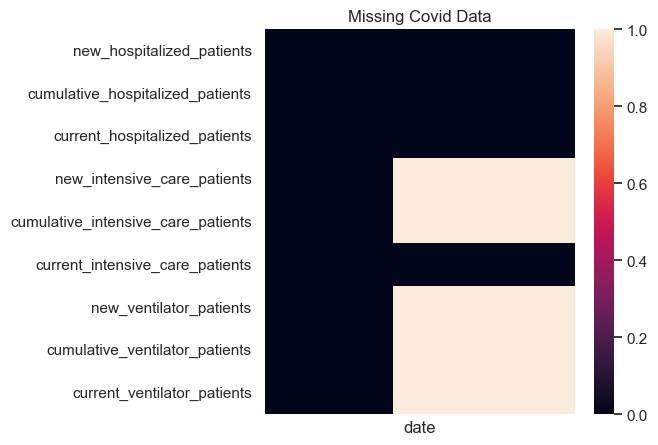

In [125]:

plt.figure(figsize=(5,5))
sns.heatmap(hospitalizations_df.isna().T,xticklabels = [], cbar=True)
plt.title("Missing Covid Data")
plt.show()

In [126]:

hospitalizations_df.drop(columns=['new_intensive_care_patients', 'new_ventilator_patients', 'current_ventilator_patients'], inplace=True) 
display(hospitalizations_df[hospitalizations_df.index > pd.to_datetime('2021-01-01')].isna().sum())


new_hospitalized_patients               0
cumulative_hospitalized_patients        0
current_hospitalized_patients           0
cumulative_intensive_care_patients    557
current_intensive_care_patients         0
cumulative_ventilator_patients        557
dtype: int64

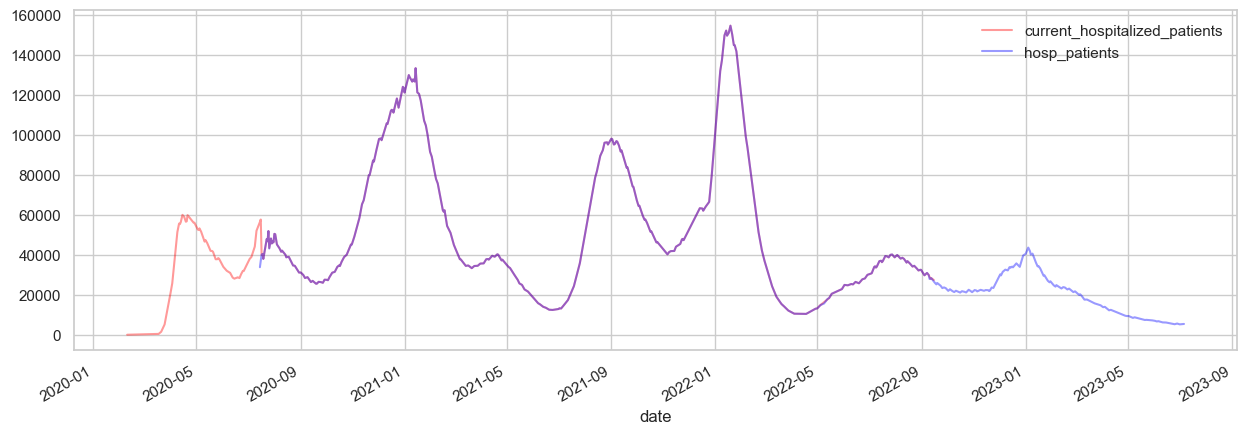

In [127]:
investigation = pd.merge(hospitalizations_df.filter(regex=f'hosp'), owid_cov.filter(regex=f'hosp'), how='outer', on='date') 

investigation[['current_hospitalized_patients', 'hosp_patients']].plot(color=['red', 'blue'], figsize=(15, 5), alpha=.4)

hospitalizations_df['current_hospitalized_patients'] = hospitalizations_df['current_hospitalized_patients'].fillna(owid_cov['hosp_patients'])

In [128]:
# Calculate all the correlations between each independent variables
hospitalizations_df.corr().style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)


,new_hospitalized_patients,cumulative_hospitalized_patients,current_hospitalized_patients,cumulative_intensive_care_patients,current_intensive_care_patients,cumulative_ventilator_patients
new_hospitalized_patients,1.000000,0.176814,0.920176,0.809281,0.836215,0.820915
cumulative_hospitalized_patients,0.176814,1.000000,0.013543,0.938068,-0.153737,0.903394
current_hospitalized_patients,0.920176,0.013543,1.000000,0.729417,0.945945,0.715918
cumulative_intensive_care_patients,0.809281,0.938068,0.729417,1.000000,0.753004,0.993970
current_intensive_care_patients,0.836215,-0.153737,0.945945,0.753004,1.000000,0.744672
cumulative_ventilator_patients,0.820915,0.903394,0.715918,0.993970,0.744672,1.000000


In [129]:
# collinear columns dropped
hospitalizations_df = hospitalizations_df.drop(columns = ['cumulative_intensive_care_patients', 'cumulative_ventilator_patients'])


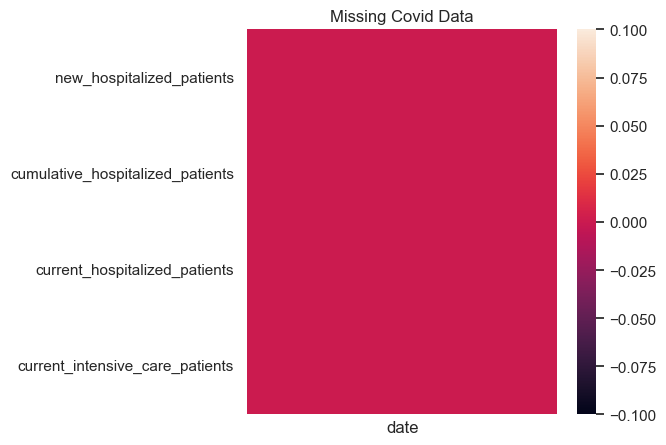

In [130]:

plt.figure(figsize=(5,5))
sns.heatmap(hospitalizations_df.isna().T,xticklabels = [], cbar=True)
plt.title("Missing Covid Data")
plt.show()

### <a id='toc4_2_5_'></a>[Final Merging of Datasets](#toc0_)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1142 entries, 2020-02-15 to 2023-04-01
Data columns (total 66 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   cancel_events                         1142 non-null   Float64
 1   gatherings_restrictions               1142 non-null   Float64
 2   infected                              1142 non-null   Int64  
 3   information_campaigns                 1142 non-null   Float64
 4   internal_movement_restrictions        1142 non-null   Float64
 5   international_movement_restrictions   1142 non-null   Float64
 6   school_closing                        1142 non-null   Float64
 7   stay_home_restrictions                1142 non-null   Float64
 8   stringency_index                      1142 non-null   Float64
 9   susceptible                           1142 non-null   Float64
 10  testing_policy                        1142 non-null   Float64
 11 

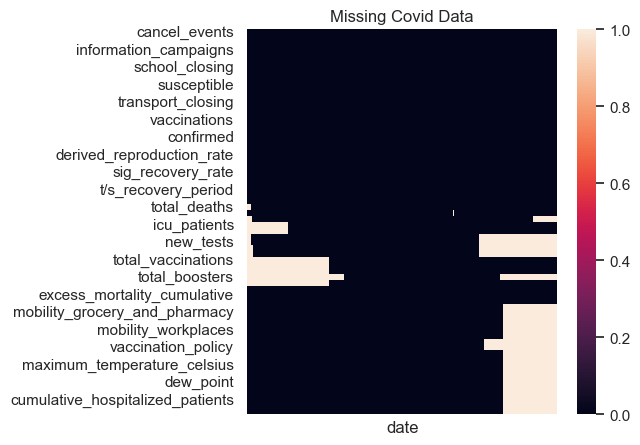

In [131]:
# Recreate Master DF
# Create a list of dataframes to be merged
time_series_dfs = [disease_df, owid_cov, mobility_df, gov_response_df, weather_df, hospitalizations_df]

# Use functools.reduce to merge all dataframes in the list on 'date' column, with 'left' join method
master_df = reduce(lambda a, b: pd.merge(a, b, how='left', right_on='date', left_on='date', suffixes=['_owid', '_gov_respons']), time_series_dfs)

# Display summary and first few rows of the master dataframe
master_df.info()

plt.figure(figsize=(5,5))
sns.heatmap(master_df.isna().T,xticklabels = [])
plt.title("Missing Covid Data")
plt.show()


In [132]:

display(last_first_missing(master_df, True).sort_values(by='min_max_variance').head(15)
                .style.background_gradient(cmap='coolwarm', subset='min_max_variance', vmin=0, vmax=.1)
                .format(lambda x: "{:,.4f}".format(x).rstrip('0').rstrip('.') if isinstance(x, (float, int)) else x)
        )


,First_Data_Date,Last_Data_Date,percent,min_max_variance,min,max,mean
t/k_mortality_period,2020-02-15,2023-04-01,0,0.0025,181.0396,"217,708.8652","2,998.9918"
rainfall_mm,2020-02-15,2022-09-14,17.4256,0.0042,0,68.4107,1.5438
mobility_grocery_and_pharmacy,2020-02-15,2022-09-12,17.6007,0.006,-61,36,-2.5303
new_cases,2020-02-15,2023-04-01,0,0.0102,0,"1,265,520","90,082.2259"
t/r_infection_period,2020-02-15,2023-04-01,0,0.0105,4.7084,127.4036,15.4596
mobility_retail_and_recreation,2020-02-15,2022-09-12,17.6007,0.0128,-82,14,-12.6355
reproduction_rate,2020-03-05,2023-01-02,9.4571,0.0161,0.52,3.61,1.0809
derived_reproduction_rate,2020-02-15,2023-04-01,0,0.0176,0.211,39.2982,2.3809
infected,2020-02-15,2023-04-01,0,0.0194,15,"13,384,650","1,529,243.3205"
snowfall_mm,2020-02-15,2022-09-14,17.4256,0.0204,0,239.6067,8.1946


In [133]:
# Initialize an empty dataframe to hold the column names
df_columns = pd.DataFrame()

# Iterate over each dataframe in the list and add their column names to df_columns
for i, df in enumerate(time_series_dfs):
    df_name = [x for x in globals() if globals()[x] is df][0]
    df_columns[df_name] = pd.Series(df.columns)

df_columns.fillna('', inplace=True)

# Display the dataframe
def highlight_string(data, string="your_string", color='yellow'):
    attr = f'background-color: {color}'
    return np.where(data.str.contains(string), attr, '')



In [134]:
drop_list = ['vaccinations_boosters', 'vaccinated_full', 'vaccinated_once', 'vaccinations', 'new_deaths', 'total_deaths',
        'total_cases', 'new_cases', 'tests', 'vaccinations_boosters']

checking = 'inten|icu' # total_test|positive|

display(df_columns.style.apply(highlight_string, string=checking, color='yellow'))


,disease_df,owid_cov,mobility_df,gov_response_df,weather_df,hospitalizations_df
0,cancel_events,total_cases,mobility_retail_and_recreation,facial_coverings,average_temperature_celsius,new_hospitalized_patients
1,gatherings_restrictions,new_cases,mobility_grocery_and_pharmacy,vaccination_policy,minimum_temperature_celsius,cumulative_hospitalized_patients
2,infected,total_deaths,mobility_parks,,maximum_temperature_celsius,current_hospitalized_patients
3,information_campaigns,new_deaths,mobility_transit_stations,,rainfall_mm,current_intensive_care_patients
4,internal_movement_restrictions,reproduction_rate,mobility_workplaces,,snowfall_mm,
5,international_movement_restrictions,icu_patients,mobility_residential,,dew_point,
6,school_closing,hosp_patients,,,relative_humidity,
7,stay_home_restrictions,total_tests,,,,
8,stringency_index,new_tests,,,,
9,susceptible,positive_rate,,,,


,icu_patients,current_intensive_care_patients
icu_patients,1.000000,0.999984
current_intensive_care_patients,0.999984,1.000000


,First_Data_Date,Last_Data_Date,percent,min_max_variance,min,max,mean
current_intensive_care_patients,2020-02-15,2022-09-15,17.338004,0.071481,0.000000,28891.000000,11048.806144
icu_patients,2020-07-15,2023-04-01,13.222417,0.081866,1432.000000,28891.000000,10087.655903


<AxesSubplot: xlabel='date'>

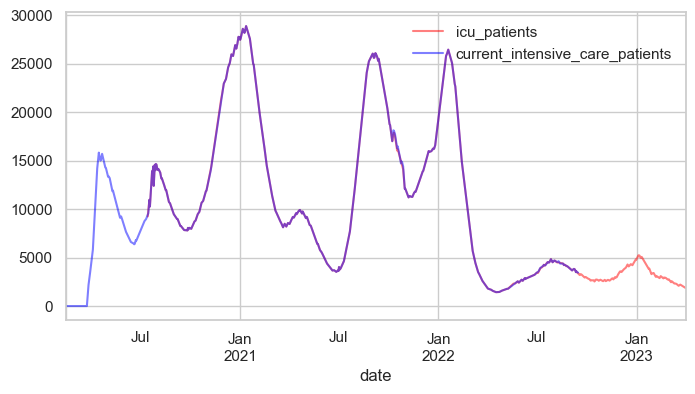

In [135]:
# Filter columns in 'master_df' based on a regular expression pattern
evaluation_df = master_df.filter(regex=f'{checking}')

# Display correlation matrix of 'evaluation_df' with background gradient styling
display(evaluation_df.corr().style.background_gradient(cmap='coolwarm'))

# Display missing values summary of 'evaluation_df' with background gradient styling
display(last_first_missing(evaluation_df, True).style.background_gradient(cmap='coolwarm'))

master_df.filter(regex=f'{checking}').plot(alpha=.5, figsize=(8, 4), color=['red', 'blue', 'orange', 'pink', 'green', 'black'])

# (evaluation_df.fatal + evaluation_df.confirmed + master_df.recovered - evaluation_df.total_cases) #.plot() 

WHY IS THERE SSUCH A BIG GAP here between confirmed and total cases???

### <a id='toc4_2_6_'></a>[Master Cleaning](#toc0_)

,First_Data_Date,Last_Data_Date,percent,min_max_variance
new_hospitalized_patients,2020-02-15,2022-09-15,17.338004,0.031952
cumulative_hospitalized_patients,2020-02-15,2022-09-15,17.338004,0.114625
current_hospitalized_patients,2020-02-15,2022-09-15,17.338004,0.046069
hosp_patients,2020-07-15,2023-04-01,13.222417,0.049650


,First_Data_Date,Last_Data_Date,percent,min_max_variance
new_hospitalized_patients,2020-02-15,2022-09-15,17.338004,0.031952
cumulative_hospitalized_patients,2020-02-15,2022-09-15,17.338004,0.114625
hosp_patients,2020-07-15,2023-04-01,13.222417,0.049650
current_hospitalized_patients,2020-02-15,2023-04-01,0.000000,0.041355


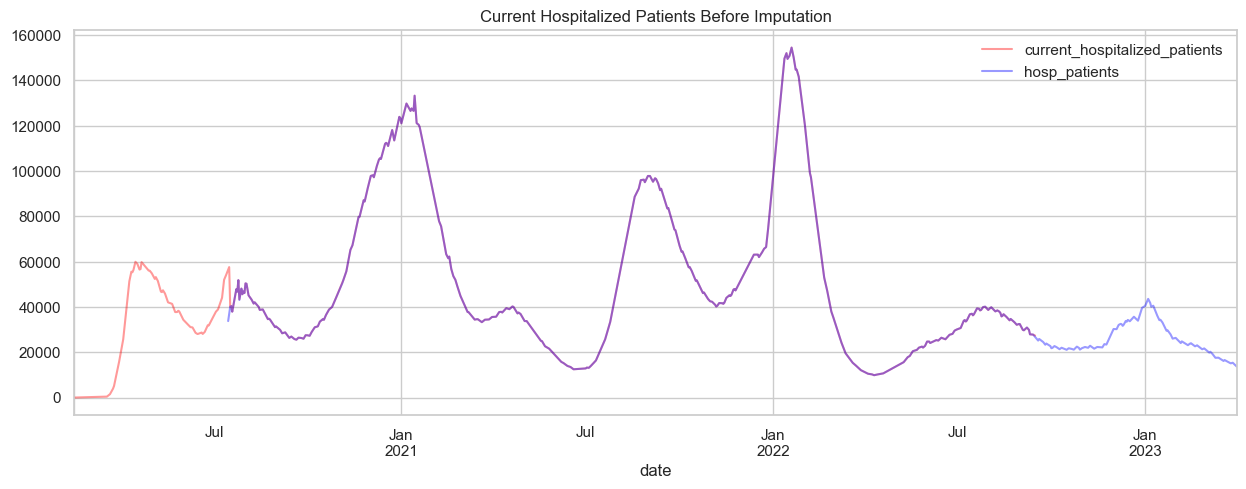

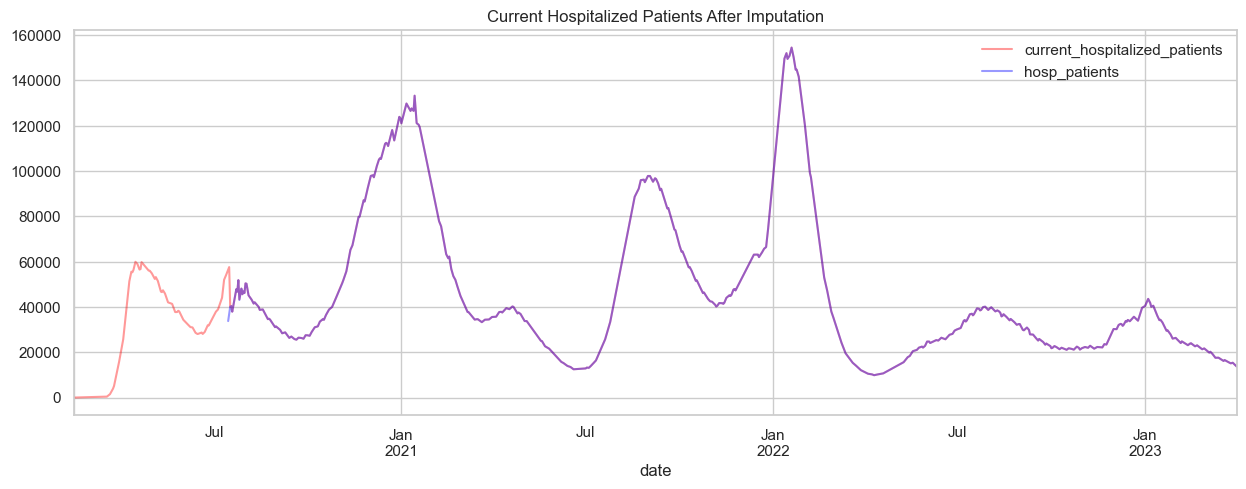

In [136]:
# # Display missing values summary of columns containing 'hosp' in their name from 'master_df' with background gradient styling
display(last_first_missing(master_df.filter(regex=f'hosp')).style.background_gradient(cmap='coolwarm'))

# # Plot 'current_hospitalized_patients' and 'hosp_patients' columns with two colors, specifying figure size and transparency
master_df[['current_hospitalized_patients', 'hosp_patients']].plot(color=['red', 'blue'], figsize=(15, 5), alpha=.4, title='Current Hospitalized Patients Before Imputation')

# # Combine 'current_hospitalized_patients' and 'hosp_patients' columns in 'master_df', filling missing values
master_df['current_hospitalized_patients'] = master_df['current_hospitalized_patients'].combine_first(master_df['hosp_patients'])

# # Plot 'current_hospitalized_patients' and 'hosp_patients' columns with two colors, specifying figure size and transparency
master_df[['current_hospitalized_patients', 'hosp_patients']].plot(color=['red', 'blue'], figsize=(15, 5), alpha=.4, title='Current Hospitalized Patients After Imputation')

display(last_first_missing(master_df.filter(regex=f'hosp')).style.background_gradient(cmap='coolwarm'))

master_df = master_df.drop(columns='hosp_patients')

,First_Data_Date,Last_Data_Date,percent,min_max_variance
current_intensive_care_patients,2020-02-15,2022-09-15,17.338004,0.071481
icu_patients,2020-07-15,2023-04-01,13.222417,0.081866


,First_Data_Date,Last_Data_Date,percent,min_max_variance
icu_patients,2020-07-15,2023-04-01,13.222417,0.081866
current_intensive_care_patients,2020-02-15,2023-04-01,0.000000,0.069803


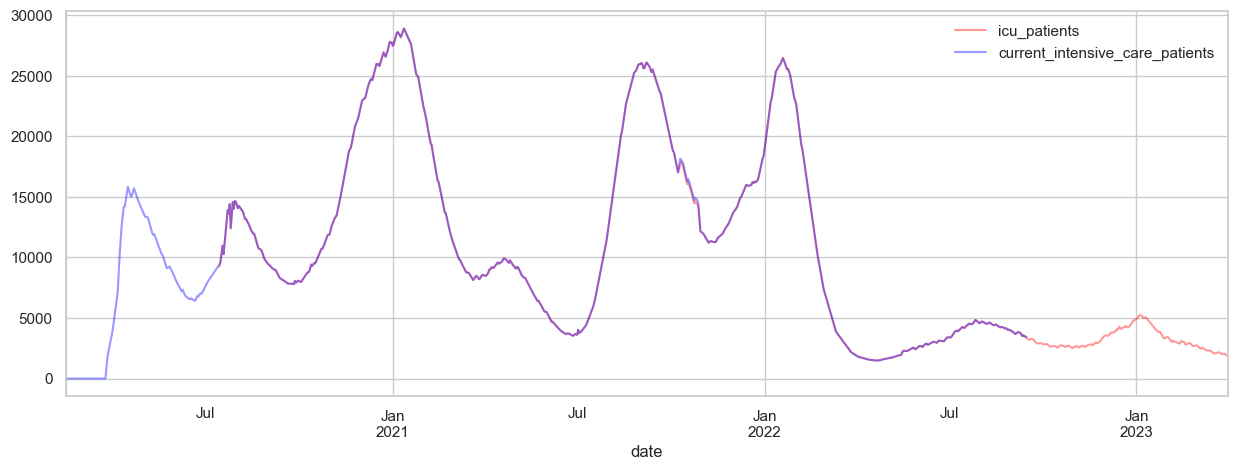

In [137]:
# Display missing values summary of columns containing 'icu' or 'intens' in their name from 'master_df' with background gradient styling
display(last_first_missing(master_df.filter(regex=f'icu|intens')).style.background_gradient(cmap='coolwarm'))

# Plot columns containing 'icu' or 'intens' in their name, excluding 'cumulative_intensive_care_patients', with two colors, specifying figure size and transparency
master_df.filter(regex=f'icu|intens').plot(color=['red', 'blue'], figsize=(15, 5), alpha=.4)

# Combine 'current_intensive_care_patients' and 'icu_patients' columns in 'master_df', filling missing values
master_df['current_intensive_care_patients'] = master_df['current_intensive_care_patients'].fillna(master_df['icu_patients'])

# Display missing values summary of columns containing 'icu' or 'intens' in their name from 'master_df' with background gradient styling
display(last_first_missing(master_df.filter(regex=f'icu|intens')).style.background_gradient(cmap='coolwarm'))

master_df = master_df.drop(columns='icu_patients')

# <a id='toc5_'></a>[Resume Here](#toc0_)

,derived_reproduction_rate,reproduction_rate
derived_reproduction_rate,1.000000,0.930874
reproduction_rate,0.930874,1.000000


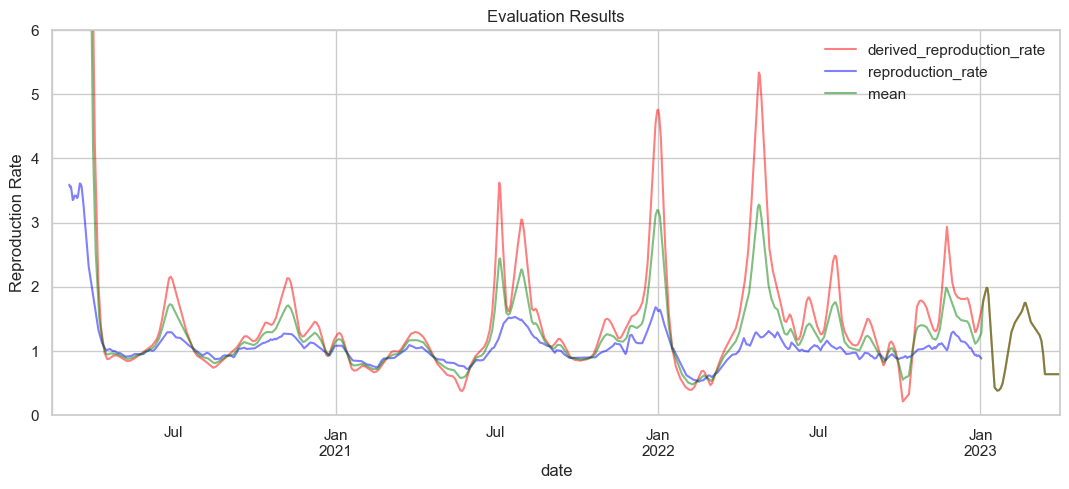

In [138]:

# Filter columns in 'master_df' based on a regular expression pattern
evaluation_df = master_df.filter(regex='reproduc')

# Display correlation matrix of 'evaluation_df' with background gradient styling
display(evaluation_df.corr().style.background_gradient(cmap='coolwarm'))

# Plot the evaluation_df DataFrame with transparency and custom colors
evaluation_df.plot(alpha=0.5, color=['red', 'blue', 'orange', 'pink', 'green', 'black'])

# Set the y-axis limits
plt.ylim(0, 6)

# Plot the mean of evaluation_df along the columns axis and label it as 'mean'
evaluation_df.mean(axis=1).plot(label='mean', color='green', figsize=(13, 5), alpha=0.5)

# # Add a legend to the plot
plt.legend()
plt.ylabel('Reproduction Rate')

# # Set the title of the graph
plt.title('Evaluation Results')

master_df = master_df.drop(columns = ['reproduction_rate'])

I decided to keep the derived reproduction rate because it had more variance and information, also I better understood where it was being derived from making the interpretabilty easier.

In [139]:
display(last_first_missing(master_df).query('percent > 0')\
    .sort_values(by='First_Data_Date', ascending=False)\
        .head(15).style.background_gradient(cmap='coolwarm'))


,First_Data_Date,Last_Data_Date,percent,min_max_variance
total_boosters,2021-02-04,2022-09-01,49.649737,0.160497
new_vaccinations,2020-12-14,2023-04-01,26.532399,0.034228
total_vaccinations,2020-12-13,2023-04-01,26.444834,0.088168
people_vaccinated,2020-12-13,2023-04-01,26.444834,0.079155
people_fully_vaccinated,2020-12-13,2023-04-01,26.444834,0.093268
positive_rate,2020-03-07,2022-06-18,26.970228,0.038199
tests_per_case,2020-03-07,2022-06-18,26.970228,0.040319
new_tests,2020-03-01,2022-06-18,26.444834,0.034794
total_tests,2020-03-01,2022-06-18,26.444834,0.106032
total_deaths,2020-02-29,2023-04-01,1.225919,0.104914


### <a id='toc5_1_1_'></a>[Remaining Null Values: Early Missing Data](#toc0_)

In [140]:

lfm_df = last_first_missing(master_df).query('percent > 0').sort_values(by='First_Data_Date', ascending=False)

lfm_df.loc[lfm_df.First_Data_Date > dt.date(2020, 2, 15), lfm_df.columns].style.background_gradient(cmap='coolwarm')


,First_Data_Date,Last_Data_Date,percent,min_max_variance
total_boosters,2021-02-04,2022-09-01,49.649737,0.160497
new_vaccinations,2020-12-14,2023-04-01,26.532399,0.034228
total_vaccinations,2020-12-13,2023-04-01,26.444834,0.088168
people_vaccinated,2020-12-13,2023-04-01,26.444834,0.079155
people_fully_vaccinated,2020-12-13,2023-04-01,26.444834,0.093268
positive_rate,2020-03-07,2022-06-18,26.970228,0.038199
tests_per_case,2020-03-07,2022-06-18,26.970228,0.040319
new_tests,2020-03-01,2022-06-18,26.444834,0.034794
total_tests,2020-03-01,2022-06-18,26.444834,0.106032
total_deaths,2020-02-29,2023-04-01,1.225919,0.104914


In [141]:
# For columns related to vaccinations, fill NaN values with 0 for dates before 2021-02-15.
zero_before_2021_02_05 = ['total_boosters', 'new_vaccinations', 'people_fully_vaccinated', 'total_vaccinations', 'people_vaccinated']

master_df.loc[master_df.index.date < dt.date(2021, 2, 15), zero_before_2021_02_05] = \
    master_df.loc[master_df.index.date < dt.date(2021, 2, 15), zero_before_2021_02_05].fillna(0)

master_df.loc[master_df.index.date < dt.date(2021, 2, 15), zero_before_2021_02_05].head()

,total_boosters,new_vaccinations,people_fully_vaccinated,total_vaccinations,people_vaccinated
date,,,,,
2020-02-15,0.0,0.0,0.0,0.0,0.0
2020-02-16,0.0,0.0,0.0,0.0,0.0
2020-02-17,0.0,0.0,0.0,0.0,0.0
2020-02-18,0.0,0.0,0.0,0.0,0.0
2020-02-19,0.0,0.0,0.0,0.0,0.0


In [142]:
# For certain columns, fill NaN values with the next available value (backfill) for dates before 2021-02-15.
bfill_before_2020_04_01 = ['tests_per_case', 'positive_rate']

master_df.loc[master_df.index.date < dt.date(2021, 2, 15), bfill_before_2020_04_01] = \
    master_df.loc[master_df.index.date < dt.date(2021, 2, 15), bfill_before_2020_04_01].fillna(method='bfill')

master_df.loc[master_df.index.date < dt.date(2021, 2, 15), bfill_before_2020_04_01].head()

,tests_per_case,positive_rate
date,,
2020-02-15,9.3,0.107
2020-02-16,9.3,0.107
2020-02-17,9.3,0.107
2020-02-18,9.3,0.107
2020-02-19,9.3,0.107


In [143]:
# Estimate 'new_tests' by multiplying 'tests_per_case' with 'confirmed' and fill NaNs in 'total_tests' using its cumulative sum.
master_df['new_tests'] = master_df['new_tests'].combine_first(master_df['tests_per_case'] * master_df['confirmed']) 

# Compute cumulative sum of 'new_tests' and use it to fill missing values in the 'total_tests' column.
master_df['total_tests'] = master_df['total_tests'].combine_first(master_df['new_tests'].cumsum()) 


master_df[['new_tests', 'total_tests']].head()

,new_tests,total_tests
date,,
2020-02-15,139.5,139.5
2020-02-16,139.5,279.0
2020-02-17,232.5,511.5
2020-02-18,232.5,744.0
2020-02-19,232.5,976.5


In [144]:
# Display updated and styled subset of lfm_df where 'First_Data_Date' is after 2020-02-15.
lfm_df = last_first_missing(master_df).query('percent > 0').sort_values(by='First_Data_Date', ascending=False)

lfm_df.loc[lfm_df.First_Data_Date > dt.date(2020, 2, 15), lfm_df.columns].style.background_gradient(cmap='coolwarm')




,First_Data_Date,Last_Data_Date,percent,min_max_variance
total_deaths,2020-02-29,2023-04-01,1.225919,0.104914


In [145]:
master_df = master_df.drop(columns=drop_list)




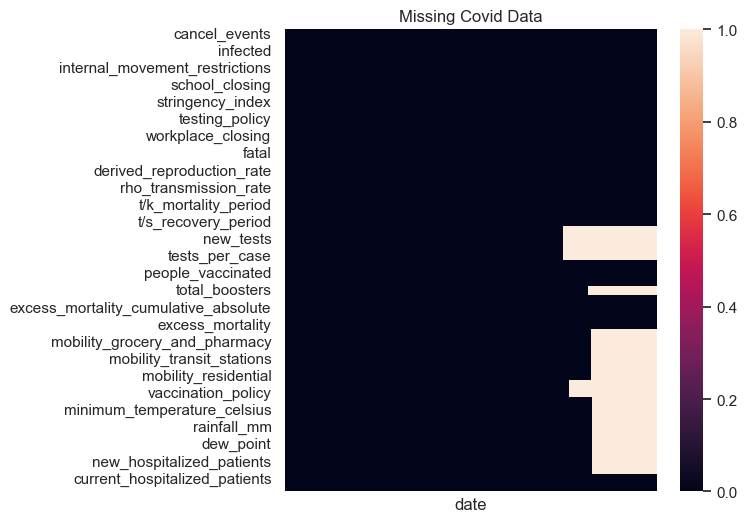

In [146]:
#heat map to see how much values need to updated
plt.figure(figsize=(6,6))
sns.heatmap(master_df.isna().T,xticklabels = [])
plt.title("Missing Covid Data")
plt.show()



### <a id='toc5_1_2_'></a>[Remaining Null Values: Later Missing Data](#toc0_)

In [159]:
lfm_df.loc[lfm_df.Last_Data_Date < dt.date(2023, 2, 20), lfm_df.columns].sort_values('Last_Data_Date')\
    .style.background_gradient(cmap='coolwarm')



854

The problem with predicting things into the future is that... well that is exactly what I am trying to do in the first place with covid. I wanted to build my base model with all the variables I could before going into that.



## <a id='toc5_2_'></a>[Feature Engineering](#toc0_)

In [148]:
# # Day to Day Differences
master_df['new_confirmed'] = master_df['confirmed'].diff()
master_df['new_fatal'] = master_df['fatal'].diff()
master_df['new_recovered'] = master_df['recovered'].diff()
master_df['new_susceptible'] = master_df['susceptible'].diff()
master_df['total_removed'] = master_df['fatal'] + master_df['recovered']

master_df.fillna(method='backfill', inplace=True)

# # Division and Ratios
# eng.div(numerator="Fatal", denominator="Total_Removed", new="Fatal_to_Total_Removed")

In [149]:
# master_df.to_parquet('../Data/master_df.csv', index=True)


In [150]:
master_df = pd.read_parquet('../Data/master_df.parquet')

dfSummary(master_df, is_collapsible=True)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,cancel_events[Float64],Mean (sd) : 1.3 (0.9)min < med < max:0.0 < 2.0 < 2.0IQR (CV) : 2.0 (1.4),3 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKcAAABDCAYAAAD5wxV4AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8o6BhiAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABjUlEQVR4nO3dYWriQBzG4ZkiVr8kiOBhPEQPu4fwNrKMH7ZlQdMTGGs2oW/Z5/kaR2L4IQw4f+swDAUSvXz3DcA9q+++AX62Wuu2lLKeuPzvMAzv9y6Kk8lqrdv9fv/Wdd1uyvrL5fK71vrrXqDi5F+su67bHY/H977vP55Z2FrbnE6n3fl8XpdSxMky+r7/OBwOfyYs3Y5dtCEiljiJJU5iiZNY4iSWOIklTmKJk1jiJJY4iSVOYomTWOIkljiJJU5iiZNY4iSWOIklTmKJk1jiJJY4iSVOYomTWOIk1sOJH0sOaoIxo3EuPagJxjz65lx0UBOM+dIgr6UGNcEYGyJiiZNY4iSWOIklTmKJk1jiJJY4iSVOYomTWOIkljiJJU5iiZNY/vtyZk4OzEecM3JyYF7inJeTAzMS5wKcHJiHDRGxxEkscRJLnMQSJ7HESSxxEkucxBInscRJLHESS5zEEiexvvSrpNba5tk3bq1trtfrqpTS1VqfvrEf6rWU/+p5dbfbbTX18z56zSe4SXP3btVCNAAAAABJRU5ErkJggg=="">",0(0.0%)
2,gatherings_restrictions[Float64],Mean (sd) : 2.5 (1.8)min < med < max:0.0 < 4.0 < 4.0IQR (CV) : 4.0 (1.4),5 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKcAAABDCAYAAAD5wxV4AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8o6BhiAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABs0lEQVR4nO3dQWrCQBhA4X+KWN1MEMHDeIgetofwNlLGRZWCpqsujUYbfDO8bxvHBHkRJuBv6vs+JKK3V1+AdM3s1ReguqWUlhExf3D5T9/3x2sHjVMPSykt1+v1R8559cj6w+HwlVL6vBaoceoZ85zzarvdHruuO41ZWEpZ7Ha71X6/n0eEcWoaXdedNpvN9wNLl0MH3RAJyziFZZzCMk5hGaewjFNYxiks4xSWcQrLOIVlnMIyTmEZp7CMU1jGKSzjFJZxCss4hWWcwjJOYRmnsIxTWDd/GjzlRAdpyGCcU090kIbc+uacdKKDNOSuiR9TTXSQhrghEpZxCss4hWWcwjJOYRmnsIxTWMYpLOMUlnEKyziFZZzCMk5hGaewjFNYxiks4xSWcQrLOIVlnMLyL60b0eJ8AeNsQKvzBYyzDU3OFzDOhrQ2X8ANkbCMU1jGKSzjFJZxCgu7W2/xobLGQcZZ80Nlb6r/g4wzKn2oXPNNRUSNMyKqfKhc5U1FhY6zVhXeVEh3xVlKWYx941LK4nw+zyIip5TGLs+Xy2X2gvM+6/3vGsYurPTzeuq8t17zC756xPtWt2FhAAAAAElFTkSuQmCC"">",0(0.0%)
3,infected[Int64],Mean (sd) : 1529243.3 (1862254.2)min < med < max:15.0 < 1007507.5 < 13384650.0IQR (CV) : 1211292.2 (0.8),"1,136 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKcAAABDCAYAAAD5wxV4AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8o6BhiAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACE0lEQVR4nO3dvW7iQBiF4TMmIBOILUCCjiZ9Ckr6bXOx227PXWyPkFAwwgkCOU6VckM8Fpsj8T51PvOjV7HGGjGhrmsBjpKffgPAv9xd+oMQQl9SL/L6p7qu3yJnceO+jDOE0J9MJs9Zlo1iLr7f719CCL8JFDEu/efsZVk2Wi6Xb3meH5tcuCiKdLVajbbbbU8ScaKxi7d1Scrz/DidTl8jrt+PmAEksSCCMeKELeKELeKELeKELeKELeKELeKELeKELeKELeKELeKELeKELeKELeKELeKELeKELeKELeKELeKELeKELeKELeKELeKELeKELeKELeKELeKELeKELeKELeKELeKELeKELeKELeKErW/9Jnysqqq6krIQQsw4x8TcuKvFWZZl93w+P83n806n02l0EofEMTG4Ypyn0+kuTdP7xWJxnM1mL01mOSYG0pVv65I0GAw4JgZRWBDBFnHCFnHCFnHCFnHCFnHCFnHCFnHCFnHCFnHCFnHCFnHCFnHCFnHC1tW3zMViFz0s42QXPSTTONlFD8k0zk/sor9tLIhgizhhy/q2HqvlSj+R9N7i5X/kSUEIoS+pFzne5jO3mf3yu/pWnEVRpE1f9XA4pJJUlmW62Wzu/9fser1+iF3pV1XVLcvycTgc/k2S5Nxk9tNutzuEEP5IavyUoYV0PB7/yvN82HSwzWdu+31deqryAV/AxCjCbMoTAAAAAElFTkSuQmCC"">",0(0.0%)
4,information_campaigns[Float64],Mean (sd) : 1.9 (0.3)min < med < max:0.0 < 2.0 < 2.0IQR (CV) : 0.0 (6.1),2 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKcAAABDCAYAAAD5wxV4AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8o6BhiAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABmElEQVR4nO3XQU7CQBSA4XmGFLuZpqlyDA7AITgsh2DLSRrSLqy6YFy5RKVE+Yn/t52+yUvzp0mjlJIkoodbLyCds7j1ArpvEVGnlKqZ4++llOncoXFqtoiou67b5pzbOfPjOB4jYncuUOPUNaqcc7vZbKamaV4vGRyG4XG/37d931cpJePU72ia5nW1Wr3MGK2/OvSHSFjGKSzjFJZxCss4hWWcwjJOYRmnsIxTWMYpLOMUlnEKyziFZZzCMk5hGaewjFNYxiks4xSWcQrLOIVlnMIyTmEZp7CMU1jGKSzjFJZxCss4hWWcwjJOYRmnsIxTWMYpLOMUlnEKyziFZZzCMk5hGaewjFNYxiks4xSWcQrLOIVlnMIyTmEZp7CMU1jGKSzjFJZxCss4hWWcwjJOYRmnsIxTWMYprMV3D0REnVKqZt7/XkqZZs7qn/syzoiou67b5pzbOZeP43iMiJ2Bao7vvpxVzrldr9epruu3Sy6epml5OBye+75/iojxih3vyec7Wt50i7+TT6fTYhiGx0sHfzLzAW8mQ1uCG1pdAAAAAElFTkSuQmCC"">",0(0.0%)
5,internal_movement_restrictions[Float64],Mean (sd) : 1.4 (0.5)min < med < ma

In [154]:
# Desired initial columns
initial_columns = ['new_confirmed', 'new_hospitalized_patients', 'new_fatal']

# Reorganize the columns
remaining_columns = sorted([col for col in master_df.columns if col not in initial_columns])
ordered_columns = initial_columns + remaining_columns

# Reorder the dataframe based on the new column order
master_df_ordered = master_df[ordered_columns]

master_df_ordered.head()

master_df.info()
master_df.isna().sum().sum() / master_df.count().sum()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1142 entries, 2020-02-15 to 2023-04-01
Data columns (total 59 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   cancel_events                         1142 non-null   Float64
 1   gatherings_restrictions               1142 non-null   Float64
 2   infected                              1142 non-null   Int64  
 3   information_campaigns                 1142 non-null   Float64
 4   internal_movement_restrictions        1142 non-null   Float64
 5   international_movement_restrictions   1142 non-null   Float64
 6   school_closing                        1142 non-null   Float64
 7   stay_home_restrictions                1142 non-null   Float64
 8   stringency_index                      1142 non-null   Float64
 9   susceptible                           1142 non-null   Float64
 10  testing_policy                        1142 non-null   Float64
 11 

0.07827228063437194

TypeError: cannot do slice indexing on DatetimeIndex with these indexers [2] of type int

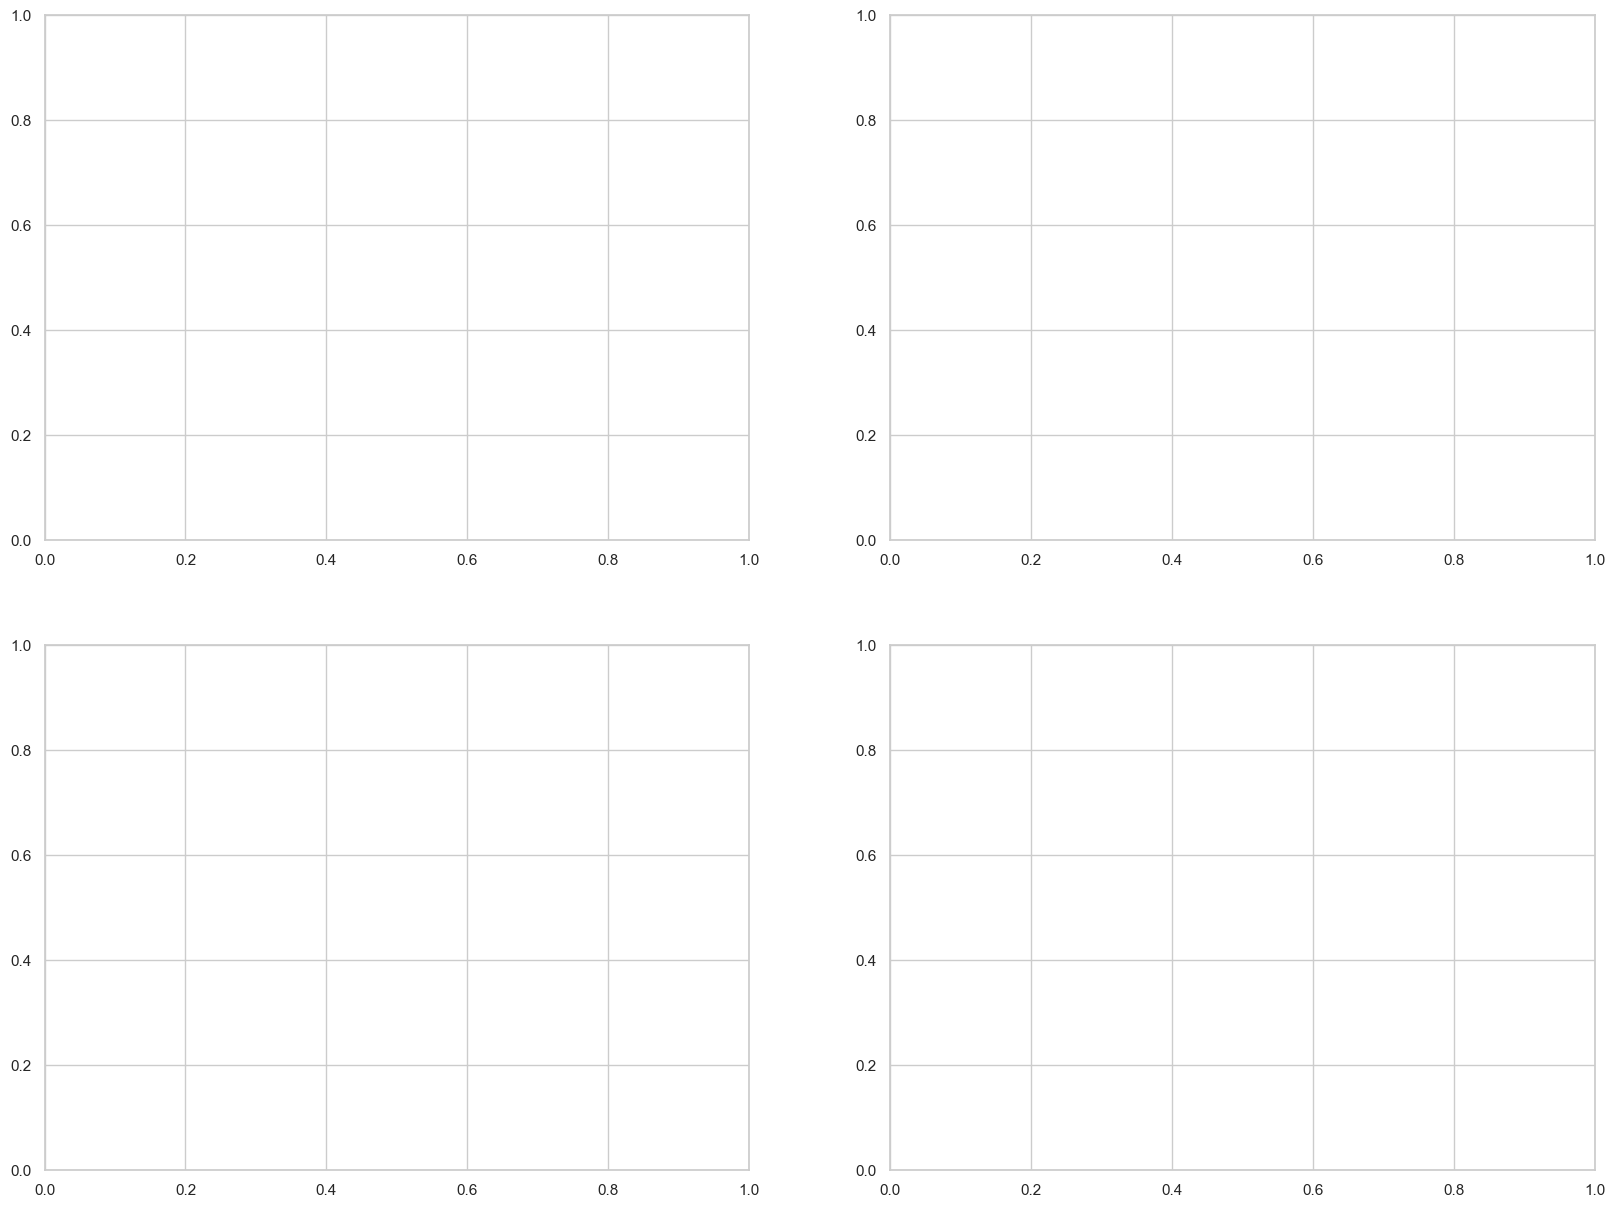

In [152]:
# # Create a figure with two columns for subplots
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

# # Plot original data in the left column (axes[:, 0])
# master_df.loc[:2, dimensional_parameters].dropna().plot(subplots=True, ax=axes[:, 0], grid=True)

# # Plot interpolated data in the right column (axes[:, 1])
# master_df.loc[2:, [ ' ', 'derived_reproduction_rate']].plot(subplots=True, ax=axes[:, 1], grid=True)

# # plt.plot()
# # Adjust layout to prevent overlap
# plt.tight_layout()
# plt.show()
# master_df[non_dim_parameters + ['derived_reproduction_rate']]


In [ ]:
# drop these too: 
# Fillna 0
# master_df[master_df.date < date(2020, 2, 20), ' '].fillna(0)
# master_df[master_df.date > date(2023, 2, 20), ' '].fillna(0)


# These two need to be merged onto each other: ['current_hospitalized_patients', 'hosp_patients']

# #Fillna BFILL
# # Null Patterns


### ENdings
# 2022-06-19 no more: 'total_test', 'new_tests', 'positive_rate', 'tests_per_case'
# 2022-07-07 no more: 'facial_coverings', 'vaccination_policy'
# 2022-09-02 no more: 'total_boosters'
# 2022-09-[13-15] no more: mobility data or weather data respectively
# 2022-12-31 no more: stringency index data


# Fill Zero: 'icu_patients', 'hosp_patients', 'total_tests', 'new_tests', 'total_boosters' before 2022.fillna()
# Fill FFill:
# Fill FFill then Zero:  'total_tests', 'new_tests', 'positive_rate', 'tests_per_case'
# Fill BFill:  'excess_mortality_cumulative', 'excess_mortality', 'excess_mortality_cumulative_absolute'
# Fill Mean: 
# Fill Linear Regression: 'total_boosters' then zero, 
# Fill SARIMA: 'positive_rate'
# Fix Negatives: 



# vaccinations_boosters ------ imputation if possible ??? there is no data after 2022-09-01
# hospital ------ 2022-09-15 is last date of record for : cumulative_hospitalized_patients and new hospitalizations. 
        # could linearly extrapolate from confirmed cases

# icu --- 2022-09-15 is last date of record for : cumulative_intensive_care_patients and new_intensive_care_patients
        # could linearly extrapolate from confirmed cases

# death vs fatal: done no changes
# cases vs confirmed: done no changes
# tests are done: but no data after 2022-06-18. might correlate with some other cumulative function
        # could linearly extrapolate from confirmed cases assuming a constant ratio of tests to cases

# confirm and positive look good: 



# vaccinations_boosters ------ imputation if possible ??? there is no data after 2022-09-01
# hospital ------ 2022-09-15 is last date of record for : cumulative_hospitalized_patients and new hospitalizations. 
        # could linearly extrapolate from confirmed cases

# icu --- 2022-09-15 is last date of record for : cumulative_intensive_care_patients and new_intensive_care_patients
        # could linearly extrapolate from confirmed cases

# death vs fatal: done no changes
# cases vs confirmed: done no changes
# tests are done: but no data after 2022-06-18. might correlate with some other cumulative function
        # could linearly extrapolate from confirmed cases assuming a constant ratio of tests to cases

# confirm and positive look good: 

# decided to drop 'total_cases' because I understood this dataset not as well. I dropped new cases for good measure. 

# <a id='toc6_'></a>[***DATA LEAKAGE ALERT***](#toc0_)

In [ ]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# from sklearn.ensemble import ExtraTreesRegressor

# # Initialize the imputer
# imputer = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=100, random_state=42))

# # Fit the imputer on the dataframe and transform
# df_imputed = imputer.fit_transform(hospitalizations_df)

# # Convert back to pandas dataframe and assign column names
# df_imputed = pd.DataFrame(df_imputed, columns=master_df.columns)

# df_imputed


In [ ]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# from sklearn.ensemble import ExtraTreesRegressor

# # Initialize the imputer
# imputer = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10, random_state=0))

# # Fit the imputer on the dataframe and transform
# df_imputed = imputer.fit_transform(master_df)

# # Convert back to pandas dataframe and assign column names
# df_imputed = pd.DataFrame(df_imputed, columns=master_df.columns)

# df_imputed


### <a id='toc6_1_1_'></a>[Extra Code](#toc0_)

In [ ]:
# disease_df.stringency_index, gov_response_df.stringency_index

# delta = round(pd.merge(disease_df.stringency_index, owid_cov.stringency_index, how='outer', on='date', suffixes=['_dise', '_gov']), 2) #.corr()# .tail().T.style.background_gradient(cmap='coolwarm')

# delta.plot()
# joined_df = disease_df[['stringency_index']].combine_first(gov_response_df[['stringency_index']])
# joined_df.plot()




# replace_nans_column = 'new_intensive_care_patients'

# mask = (hospitalizations_df.index < pd.to_datetime('2021-01-01')) & (hospitalizations_df[replace_nans_column] != hospitalizations_df[replace_nans_column])
# hospitalizations_df.loc[mask, replace_nans_column] = 0


# # replace_nans_column = 'new_ventilator_patients'

# # mask = (hospitalizations_df.index < pd.to_datetime('2021-01-01')) & (hospitalizations_df[replace_nans_column] != hospitalizations_df[replace_nans_column])
# # hospitalizations_df.loc[mask, replace_nans_column] = 0



In [ ]:

# # Growth factor: (delta Number_n) / (delta Number_n)
# df = df.diff() / df.diff().shift(freq="D")

# # Rolling mean (window: 7 days)
# df = df.rolling(7).mean().dropna().loc[:covid_df["Date"].max(), :]
# numeric_columns_assessment(eng.all()).T

In [ ]:
# """
# Cell generated by Data Wrangler.
# """
# def clean_data(df):
#     # Filter rows based on column: 'location_key'
#     # df = df[df['location_key'].str.contains(r"^(US|CA|DE|GB|FR|JP|AU|BR|ZA|IN)$", na=False)]
#     df = df[df['location_key'].str.contains(r"^(US)$", na=False)] # only the us to start

#     # Change column type to datetime64[ns] for column: 'date'
#     try:
#         df = df.astype({'date': 'datetime64[ns]'})
#     except:
#         pass
#     # Change column type to category for column: 'location_key'
#     df = df.astype({'location_key': 'category'})
#     return df


# time_series_dfs = list(map(clean_data, timeland_df))

# # # Assume dfs is your list of dataframes
# time_series_dfs = reduce(lambda left,right: pd.merge(left,right,on=['location_key', 'date'], how='left'), time_series_dfs).copy()


In [ ]:
# time_series_dfs.to_parquet(f'{folder_holder}time_series_dfs.parquet.gzip', compression='gzip')

# time_series_dfs = pd.read_parquet(f'{folder_holder}time_series_dfs.parquet.gzip')

In [ ]:
# time_series_dfs_line_plot = time_series_dfs.dropna(subset='new_confirmed').copy()
# # sns.lineplot(data = time_series_dfs_line_plot, x = 'date', y = 'new_confirmed')

# time_series_dfs_line_plot.plot(x = 'date', y = 'new_confirmed', figsize = (15, 10))

# # add lines for each column
# fig = px.line(time_series_dfs_line_plot, x=air_traffic.index, y=air_traffic.columns,)

# # axis labels and title
# fig.update_layout(
#     yaxis_title="Passenger-miles (billions)", 
#     legend_title="", 
#     title="Daily air travel from 1979 to 2002"
# )

# # activate slider
# fig.update_xaxes(rangeslider_visible=True)

# fig.show()

In [ ]:
# folder_holder = "C://Users/Samsickle/Documents/BrainStation_Capstone/Data/"
# # C:\Users\Samsickle\Documents\BrainStation_Capstone\Data

# # # # time series data
# # hospitalizations_df = pd.read_csv(f'{folder_holder}hospitalizations.csv') # 2
# # mobility_df = pd.read_csv(f'{folder_holder}mobility.csv') # 4
# # gov_response_df = pd.read_csv(f'{folder_holder}oxford-government-response.csv') # 5
# # weather_df = pd.read_csv(f'{folder_holder}weather.csv') # 6

# epid_df = pd.read_csv(f'{folder_holder}epidemiology.csv') # 1
# # vac_df = pd.read_csv(f'{folder_holder}vaccinations.csv') # 3


In [ ]:
# epid_df.sample(5)

In [ ]:
# Performs a Fillna with FFill on the data set or a fillna with a 0 if there is no previous value
# Retrieves only the dates between '2020-01-01' and '2022-09-15'

# eng.clean(kinds=['resample', 'fillna'], date_range=('2020-01-03', '2022-09-15'))
# eng.all().query('ISO3 == @country_ISO3').isna().sum().sum()

# creates an engine with only USA data and with the desire date
# complement does three things, forces always increasing cumulate values, estimates recovered cases using value of estimated recovery period

# eng.subset(geo=country_ISO3, start_date='2020-01-03', end_date='2022-09-15', complement=True)
# eng.all().ISO3.unique(), eng.all().Date.min(), eng.all().Date.max()
# Uses the SIR model to estimate the number of infected and susceptible people

# main_variables = ['Infected', 'Susceptible']
# eng.transform()
# eng.all().query('ISO3 == @country_ISO3').info()
# eng.all().query('ISO3 == @country_ISO3')[main_variables].describe().T
# estimates the length of recovery and the length of the incubation period


# eng.clean()
# eng.transform()


# actual_df, status, _ = eng.subset(geo=country_ISO3, start_date='2020-01-03', end_date='2022-09-15', complement=True)
# print(status)
# actual_df.tail()



# with_df, status, status_dict = eng.subset(geo=@country_ISO3, start_date='2020-01-01', end_date='2022-09-15', complement=True)
# print(f"{status}\n")
# print(status_dict)
# with_df.info()
# with_df.head()


# """
# Cell generated by Data Wrangler.
# """
# def clean_data(with_df):
#     # Replace all instances of 0 with 0 in column: 'Positive_rate'
#     with_df.loc[with_df['Positive_rate'] != with_df['Positive_rate'], 'Positive_rate'] = 0
#     with_df.loc[with_df['Positive_rate'] == np.inf, 'Positive_rate'] = 0
#     return with_df

# with_df_clean = clean_data(with_df.copy())
# with_df_clean.head()
# cs.line_plot(with_df[["Confirmed", "Fatal", "Recovered"]], title="USA: records WITH complement")
# with_df.info()

# snr_act = cs.ODEScenario.auto_build(geo=country_ISO3, model=cs.SIRFModel, complement=True)

# snr_act.simulate(name="Baseline");
# dyn_act = snr_act.to_dynamics(name="Baseline")
# # Show summary
# display(dyn_act.summary())
# # Simulation
# dyn_act_df = dyn_act.simulate(model_specific=False)
# cs.line_plot(
#     dyn_act_df.drop("Susceptible", axis=1), "USA: Simulated data (Baseline scenario)")

Data Wireframe:

1. Date and Location:
    - 'date' - the day of the observations
    - 'location_key' - the country of the observations. I choose ten countries of interest in different regions

United States (US)  
Canada (CA)  
Germany (DE)  
United Kingdom (GB)  
France (FR)  
Japan (JP)  
Australia (AU)  
Brazil (BR)  
South Africa (ZA)  
India (IN)  
These countries are often used as indicators for their respective regions due to their significant economic influence, political stability, and comprehensive data collection practices.

2. COVID-19 Statistics:
    - 'new_confirmed' (New Positive Cases) - the number of new confirmed cases of COVID-19, this includes some negative numbers to account for data corrections in the previous days, however because these numbers are aggregated accross a whole country, the negative numbers are often very small and remain positive
    - 'new_deceased' (New Deaths) - the number of new deaths due to COVID-19 also shares the negative number problem
    - 'new_hospitalized_patients' (New Hospitalizations) 

3. Mobility Data:
    - 'mobility_retail_and_recreation'
    - 'mobility_grocery_and_pharmacy'
    - 'mobility_parks'
    - 'mobility_transit_stations'
    - 'mobility_workplaces'
    - 'mobility_residential'



4. Vaccination Data:
    - 'new_persons_vaccinated'
    - 'cumulative_persons_vaccinated'
    - 'new_persons_fully_vaccinated'
    - 'cumulative_persons_fully_vaccinated'
    - 'new_vaccine_doses_administered'
    - 'cumulative_vaccine_doses_administered'

5. Policy Measures:
    - 'school_closing'
    - 'workplace_closing'
    - 'cancel_public_events'
    - 'restrictions_on_gatherings'
    - 'public_transport_closing'
    - 'stay_at_home_requirements'
    - 'restrictions_on_internal_movement'
    - 'international_travel_controls'
    - 'income_support'
    - 'debt_relief'
    - 'fiscal_measures'
    - 'international_support'
    - 'public_information_campaigns'
    - 'testing_policy'
    - 'contact_tracing'
    - 'emergency_investment_in_healthcare'
    - 'investment_in_vaccines'
    - 'facial_coverings'
    - 'vaccination_policy'
    - 'stringency_index'

6. Weather Data:
    - 'average_temperature_celsius'
    - 'minimum_temperature_celsius'
    - 'maximum_temperature_celsius'
    - 'rainfall_mm'
    - 'snowfall_mm'
    - 'dew_point'
    - 'relative_humidity'


In [ ]:
# # location dfs
# geography_df = pd.read_csv(f'{folder_holder}geography.csv') #1
# health_df = pd.read_csv(f'{folder_holder}health.csv') #2
# demographics_df = pd.read_csv(f'{folder_holder}demographics.csv') #3
# economics_df = pd.read_csv(f'{folder_holder}economy.csv') #4


# locationland_df = [geography_df, health_df, demographics_df, economics_df]

In [ ]:
# location_df = list(map(clean_data, locationland_df))

# # Assume dfs is your list of dataframes
# location_df = reduce(lambda left,right: pd.merge(left,right,on='location_key', how='left'), location_df).copy()

# location_df.head()


In [ ]:

# location_df.to_pickle('../Data/location_df.pkl')
# location_df = pd.read_pickle('../Data/location_df.pkl')

# location_df.sample(3)

This dataframe provides a comprehensive snapshot of COVID-19 data, mobility metrics, government restrictions, and weather conditions for specific locations on specific dates. Here's a brief overview of the columns:

1. `Entry ID`: A unique identifier for each row in the dataframe.
2. `Date`: The date for the day on which the data was recorded.
3. `Location Key`: A code representing the location (10 different countries in total) for which the data is reported.

4. `New Confirmed`: The number of new confirmed COVID-19 cases on the given date.
5. `New Deceased`: The number of new COVID-19 related deaths on the given date.
6. `New Recovered`: The number of new recoveries from COVID-19 on the given date.
7. `New Tested`: The number of new COVID-19 tests conducted on the given date.

8. `New Hospitalizations`: The number of new hospitalizations due to COVID-19 on the given date.
9. `Current Hospitalizations`: The total number of current hospitalizations due to COVID-19 on the given date.

10. `New Fully Vaccinated (29+ other Vaccination Columns)`: The number of new fully vaccinated individuals on the given date. There are 29 other columns related to vaccination data here too.

11. `Retail and Recreation Mobility (5+ other Mobility Metrics)`: A measure of mobility in retail and recreation spaces, along with 5 other columns related to different aspects of mobility.

12. `School Closing (19+ other Government Restrictions)`: A measure indicating whether schools were closed on the given date, along with 19 other columns related to different government restrictions.

13. `Average Temp (6+ Other Weather Columns)`: The average temperature on the given date, along with 6 other columns related to different weather conditions.

In total there are 9880 and 82 rows for 6.3mbs of data. The main way I could increase or decrease the size of the dataset would be to include more countries, regions, or counties in the analysis. For now this is my starter df.


We are employing a strategy to impute missing values in our dataset, particularly for the variables 'ICU' and 'Ventilators'. This is achieved by leveraging the correlation between 'Hospitalizations' and these two variables, and by utilizing a simple linear regression model.

For the 'ICU' variable, the linear regression model is represented as:

$$ y = c + \beta \times x $$

where:

- $y$ represents the estimated ICU values.
- $x$ represents the 'Hospitalizations'. I subtracted the values of hospitalizations on the last day to set the value of x to 0.
- $\beta$ is calculated as the standard deviation ratio between 'Hospitalizations' and 'ICU', multiplied by the correlation strength between 'Hospitalizations' and 'ICU'. 
  - That is, $\beta = \frac{\sigma_{\text{Hospitalizations}}}{\sigma_{\text{ICU}}} \times r_{\text{Hospitalizations, ICU}}$.
- $c$ represents the last observed 'ICU' value.

For the 'Ventilators' variable, the linear regression model is represented as:

$$ y = c + \beta \times x $$

where:

- $y$ represents the estimated 'Ventilators' values.
- $x$ represents the 'Hospitalizations'. I subtracted the values of hospitalizations on the last day to set the value of x to 0.
- $\beta$ is calculated as the standard deviation ratio between 'Hospitalizations' and 'Ventilators', multiplied by the correlation strength between 'Hospitalizations' and 'Ventilators'. 
  - That is, $\beta = \frac{\sigma_{\text{Hospitalizations}}}{\sigma_{\text{Ventilators}}} \times r_{\text{Hospitalizations, Ventilators}}$.
- $c$ represents the last observed 'Ventilators' value.

These models provide a basis for filling in missing values based on the linear relationship between 'Hospitalizations' and the respective variables.

In [ ]:



# from sklearn.linear_model import LinearRegression

# last_day = hospitalizations_df['cumulative_ventilator_patients'].idxmax()



# # Define our features and target
# features = hospitalizations_df.loc[hospitalizations_df.index < last_day, ['current_intensive_care_patients', 'new_hospitalized_patients', 'cumulative_hospitalized_patients', 'current_hospitalized_patients']]
# target = hospitalizations_df.loc[hospitalizations_df.index < last_day, ['cumulative_intensive_care_patients', 'cumulative_ventilator_patients']]

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# # Initialize the model
# model = CatBoostRegressor()

# # Fit the model on the training data
# model.fit(X_train, y_train)

# # Use the model to predict on the test data
# y_pred = model.predict(X_test)

# # Now y_pred contains the predicted values for 'cumulative_ventilator_patients' and 'cumulative_intensive_care_patients' 

# model.score(X_test, y_test)
# # Plotting before imputation
# ax_before = hospitalizations_df.drop(columns='cumulative_hospitalized_patients').plot(title='Before Imputation', figsize=(10,5))
# ax_before.set_xlabel("Date")
# ax_before.set_ylabel("Count")
# ax_before.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# # Imputing missing values
# hospitalizations_df['cumulative_ventilator_patients'] = hospitalizations_df['cumulative_ventilator_patients'].fillna(predicted_vents) 
# hospitalizations_df['cumulative_intensive_care_patients'] = hospitalizations_df['cumulative_intensive_care_patients'].fillna(predicted_icu)

# # Plotting after imputation
# ax_after = hospitalizations_df.drop(columns='cumulative_hospitalized_patients').plot(title='After Imputed ICU/Vent Data', figsize=(13,5))
# ax_after.set_xlabel("Date")
# ax_after.set_ylabel("Count")
# ax_after.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# # Adjust the layout
# plt.tight_layout()
# plt.show()

# # Creating a figure with two columns
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# # Plotting the "before" graphs
# hospitalizations_df[['new_ventilator_patients', 'new_intensive_care_patients']].plot(subplots=True, ax=axes[:, 0])

# # Updating data
# daily_vents = hospitalizations_df['cumulative_ventilator_patients'].diff()
# daily_icu = hospitalizations_df['cumulative_intensive_care_patients'].diff()

# hospitalizations_df['new_ventilator_patients'] = hospitalizations_df['new_ventilator_patients'].fillna(daily_vents) 
# hospitalizations_df['new_intensive_care_patients'] = hospitalizations_df['new_intensive_care_patients'].fillna(daily_icu)

# # Plotting the "after" graphs
# hospitalizations_df[['new_ventilator_patients', 'new_intensive_care_patients']].plot(subplots=True, ax=axes[:, 1])

# # Adding titles to columns
# axes[0, 0].set_title('New Ventilator Patients (before)')
# axes[1, 0].set_title('New ICU Patients (before)')
# axes[0, 1].set_title('New Ventilator Patients (after)')
# axes[1, 1].set_title('New ICU Patients (after)')

# # Adding labels to axes
# for ax in axes.flatten():
#     ax.set_xlabel('Date')
#     ax.set_ylabel('Number of New Patients')

# plt.tight_layout()
# plt.show()

# hospitalizations_df.corr().iloc[:,-1].to_frame().style.background_gradient(cmap='coolwarm')
